# Text analysis in finance

So far we mostly discussed different methods how text can be transformed into numerical representations. Starting from frequency based bag-of-word type representations to methods including semantic meaning like Word2Vec and Doc2Vec and finally ending up at language models which capture meaning and context. Given we generate the numerical representation of text, we may use it for different applications which are specific for the domain, e.g., financial markets. In this chapter, we review general concepts which are needed for the application of text models on financial markets. Furthermore, we examine a few academic research papers with versatile applications of text models on financial markets. 

We take a look at:

* the quantification of financial sentiment
* the identification how quickly investors process text information in financial reports
* how financial climate risk is hedged with a textual approach
* how climate talk and climate disclosure can be identified in earning conference calls and annual reports

From a methodological point of view, the majority of text related tasks which are tackled in these research papers are either regression or classification tasks:

* Regression tasks usually use text as input and a numerical target variable which is derived from stock market prices
* Classification tasks collect text sequences from financial documents, annotate them and tune a model for automated classification

If text sequences are manually labeld, usually a genuine and direct link exists between text information and its label. However, labeling is a time-consuming process which can adversely be impacted by subjection. An alternative to manual labeling in the financial domain is to treat market reactions as the label, i.e., if the price of an asset in- or decreases after the release of textual information, the reaction of the market is treated as a label of positive (price increase) or negative (price decrease). This is often used to create target variables for regression tasks and liberates us from manual labeling. However, it comes along with some drawbacks. For instance, the text may include information which is relevant for the assets future development, but, investors do not react towards the information, given they learned about it before from other sources. Or, the information in the text is irrelevant for the assets future, however the market reacts to other developments, e.g., future adverse conditions of the economy. Bottom line, the link between text and market reactions is rather blurry and noisy.

## Regression tasks with stock market reactions

Nevertheless, market reactions are more often used in research due to its easier access and broader availability. So let us take a look how we exactly quantify stock market reactions. As defined in a previous chapter, we define the discrete return of this asset as:

$$
r_t = \frac{s_{t} - s_{t-1}}{s_{t-1}} = \frac{s_{t}}{s_{t-1}} - 1
$$

given the price of an asset $s_t$ at time $t$. Sometimes, one may use the log-return instead which is defined by:

$$
z_t = \ln \left( \frac{s_{t}}{s_{t-1}} \right) = \ln \left(1 + r_t\right)
$$

The choice between discrete or log-returns depends on the assumption of discrete vs. continuous trading of assets and a few practical considerations such as discrete returns are additive in the cross-section (at a given point in time) and log-returns are additive over time. 

### Event returns

Given the return of an asset at $t$ at which textual information is published, one whishes to determine if or how the information is affecting the return and by these means, the market value of an asset. Financial markets are usually very efficient. In this context this means, information which is released by, e.g., an event such as a earning call, is immediately processed by investors. Investors adjust demand and offering prices according to their believes and the effect of the event is immediately reflected in the current price. Thus, to examine if an event affects an asset's value, it is reasonable to examine the value's change over the event time period. Let the event occur at time $t$, we include the return $r_t$ which reflects the value change from the last time step before the event $t-1$ until the event at $t$. Furthermore, one adds returns following $t$, if the event impacts the value after it occurred. It is common to include only a few more time steps such as one or two. If we include too many time steps afterwards, it gets more likely that the quantified reaction is related to other events following $t$.

For instance, if Apple is holding a earning call on Wednesday, we would use the return of its stock price from Tuesday until Thursday or Tuesday until Friday to quantify the stock market reaction towards this earning call. To isolate the impact of the event as good as possible, we try to determine the quantify only the unexpected change in the stock price value. 

### Excess returns

What we expect, needs to be defined. The literature either uses excess returns or abnormal returns with this respect. Even though the exact definitions sometimes differ, excess returns are differences of the company's minus a benchmark $b$:

$$\tilde{r}_{t} = r_{t} - r_{t, b}$$

The benchmark in this context can be a market return from a broad and well diversified market portfolio such as the S\&P 1500 or the Euro Stoxx 600. The idea of this excess return is related to the fact that the majority of asset returns are positively correlated, i.e., usually the direction of the stock price movement is similar among assets on the same day. Thus, a positive return may mostly be related to the overall market movement and not to a company specific event. However, if $\tilde{r}_{t}>0$ signals a positive development in relation to the systematic market movement which may be ascribed to company specific events. Obviously, the same can be said about $\tilde{r}_{t}<0$ signaling an adverse development in relation to the market movement. 

If you take a look in the plot below, you observe the relative stock price development for large US stocks and two major indices (Russell 3000 and S\&P 500). We can see that all assets massively loose value in March 2020. This development occurred in the beginning of the Covid crisis which had a systematic impact on all assets. Systematic market movements like these are not related to company specific events and thus, should be filtered first to isolate the relationship between company information and asset price development. 

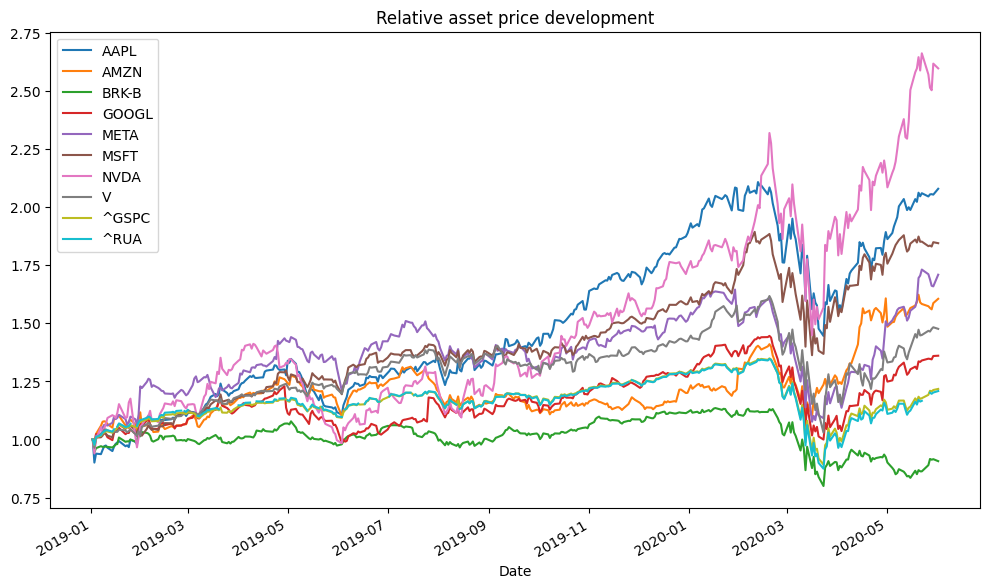

In [1]:
import pandas as pd

df_close = pd.read_csv("../data/stock_prices.csv", index_col="Date")
df_close.index = pd.to_datetime(df_close.index)

df_ttr = df_close.divide(df_close.iloc[0, :])
ttr_plot = df_ttr.loc[:pd.to_datetime("2020-06-01"), :].plot(figsize = (12, 7), title = "Relative asset price development").legend(loc = "upper left")
df_returns = df_close.divide(df_close.shift(1)).subtract(1).dropna()

### Abnormal returns

A even more sophisticated way is to estimate the expected return $\mu_t$ and subtract it from the realized return. This is called abnormal return $ar_t$

$$
ar_t = r_t - \mu_t
$$

Abnormal, because it quantifies the unexpected and by this means abnormal deviation from the expectation. To determine $\mu_t$, one can choose among different models. A popular choice is given by factor models. These models regress returns on systematic factors $\mathbf{f}_t$:

$$
r_t = \beta_0 + \boldsymbol{\beta}^T \boldsymbol{f}_t + \epsilon_t
$$

where $\boldsymbol{f}_t^T = \begin{pmatrix} f_{t, 1} & f_{t, 2} & f_{t, 3} & ...  \end{pmatrix} $ are the observations for a number of systematic factors at $t$. Once the model parameters $\beta_0, \beta_1, \beta_2, ...$ are estimated, the expected value at time $t$ is given by:

$$
\mu_t = \beta_0 + \boldsymbol{\beta}^T \boldsymbol{f}_t
$$

Thus, given this notation, $\epsilon_t = ar_t$ which is the part of $r_t$ that can not be explained by the factors at time $t$. 

For instance, let us assume to use one factor only for stock market companies, we may regress each stock's return $r_{t, i}$ on a stock market portfolio return $r_{t, m}$. To keep this simple at this stage, let us use a broad market index like the Russell 3000 to approximate the market portfolio. Common approaches in the financial area to capture these systematic effects more appropriately are factor models like the capital asset pricing model, the Fama-French three factor or the Carhardt four factor model. 

The output in the cell below is based on a model which regresses the Apple return upon the return of the Russell 3000 index:

$$
r_{t, AAPL} = \beta_0 + \beta_1 r_{t, R3000} + \epsilon_t
$$

From this regression model, we know that the expected value for Apple, given the realization of the Russell 3000 return is equal to: $\mu_{t, AAPL | r_{t, R3000}} = \beta_0 + \beta_1 r_{t, R3000}$; the filtered abnormal return is given by:

$$
\epsilon_t = r_{t, AAPL} - \beta_0 - \beta_1 r_{t, R3000}
$$

The cell below illustrates Apple's filtered and unfiltered return in the first half of 2020. We observe, that especially in the financial downturn month of the Covid pandemic (March 2020), Apple's development has been not as worse as the overall market development. 

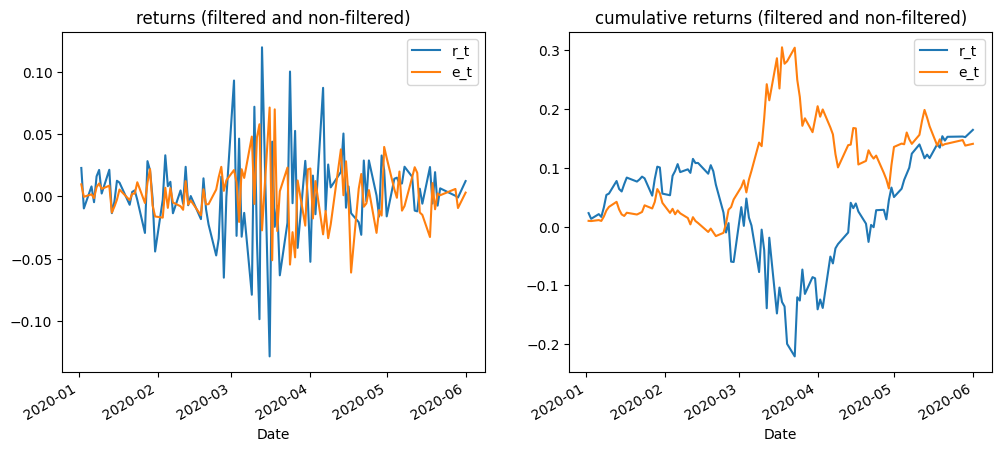

In [2]:
from sklearn.linear_model import LinearRegression
import matplotlib.pylab as plt

start_regression = pd.to_datetime("2019-01-01")
end_regression = pd.to_datetime("2020-01-01")
end_out_of_time = pd.to_datetime("2020-06-01")

ticker = "AAPL"
portfolio = "^RUA"
X = df_returns.loc[start_regression:end_regression, portfolio].values.reshape(-1, 1)
y = df_returns.loc[start_regression:end_regression, ticker].values

lr = LinearRegression()
lr.fit(X, y)

#b0, b1 = lr.intercept_, lr.coef_

X_oot = df_returns.loc[end_regression:end_out_of_time, portfolio].values.reshape(-1, 1)
y_oot = df_returns.loc[end_regression:end_out_of_time, ticker].values

e_oot = y_oot - lr.predict(X_oot)
results = pd.DataFrame(data = dict(r_t = y_oot, e_t = e_oot), index = df_returns.loc[end_regression:end_out_of_time].index)

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
results.plot(title = "returns (filtered and non-filtered)", ax = axs[0])
results.cumsum().plot(title = "cumulative returns (filtered and non-filtered)", ax = axs[1])
plt.show()

### Stock market reaction

No matter if we use the excess or the abnormal return, to finally quantify the stock market reaction around a event time $t$, we define a window size $w$ and determine the cumulative return. Let $r_t^{*}$ either represent the excess or abnormal return at time $t$, stock market reaction is equal to the cumulative return

$$
cr_{t, w} = \sum_{t=1}^{w-1} r_t^{*}
$$

Note that a model which is able to predict $cr_{t, w}$ does not predict the future development after an event. Yet, $cr_{t, w}$ can be used to gain a deeper understanding how market participants process different types of information. Positive values are interpreted as positive reactions and vice versa. 

The cell below shows the filing dates of form 8-K, 10-Q and 10-K filings made by Apple in the first half of 2020. While form 10-Q and 10-K filings refer to regular quarter and annual reports, form 8-K filings are reports which must be filed when major events occur that shareholders should know about. 

In [3]:
apple_filings_all = pd.read_csv("../data/apple_filings_all.csv")
apple_filings_all.index = pd.to_datetime(apple_filings_all.filingDate)
apple_filings_all.sort_index(inplace = True)
apple_filings_all.loc[end_regression:end_out_of_time, ]

accessionNumber  filingDate  reportDate  \
filingDate                                                 
2020-01-28  0000320193-20-000008  2020-01-28  2020-01-28   
2020-01-29  0000320193-20-000010  2020-01-29  2019-12-28   
2020-02-18  0001193125-20-039203  2020-02-18  2020-02-17   
2020-02-27  0001193125-20-050884  2020-02-27  2020-02-26   
2020-04-30  0000320193-20-000050  2020-04-30  2020-04-30   
2020-05-01  0000320193-20-000052  2020-05-01  2020-03-28   
2020-05-11  0001193125-20-139112  2020-05-11  2020-05-04   

                  acceptanceDateTime   act  form fileNumber  filmNumber  \
filingDate                                                                
2020-01-28  2020-01-28T16:30:40.000Z  34.0   8-K  001-36743    20554729   
2020-01-29  2020-01-28T18:02:44.000Z  34.0  10-Q  001-36743    20555794   
2020-02-18  2020-02-18T06:24:57.000Z  34.0   8-K  001-36743    20623292   
2020-02-27  2020-02-27T06:14:21.000Z  34.0   8-K  001-36743    20658351   
2020-04-30  2020-04-30T16:30:41.000Z  34.0   8-K  001-36743    20836131   
2020-05-01  2020-04-30T18:03:10.000Z  34.0  10-Q  001-36743    20837377   
2020-05-11  2020-05-11T16:31:15.000Z  34.0   8-K  001-36743    20865313   

                items      size  isXBRL  isInlineXBRL  \
filingDate                                              
2020-01-28  2.02,9.01    531866       1             1   
2020-01-29        NaN   9292589       1             1   
2020-02-18  7.01,9.01    310140       1             1   
2020-02-27       5.07    329670       1             1   
2020-04-30  2.02,9.01    593101       1             1   
2020-05-01        NaN  10648806       1             1   
2020-05-11  8.01,9.01    771520       1             1   

                    primaryDocument primaryDocDescription ticker     cik  
filingDate                                                                
2020-01-28   a8-kq1202012282019.htm                   8-K   AAPL  320193  
2020-01-29  a10-qq1202012282019.htm                  10-Q   AAPL  320193  
2020-02-18           d845033d8k.htm              FORM 8-K   AAPL  320193  
2020-02-27           d865740d8k.htm                   8-K   AAPL  320193  
2020-04-30    a8-kq220203282020.htm                   8-K   AAPL  320193  
2020-05-01   a10-qq220203282020.htm                  10-Q   AAPL  320193  
2020-05-11           d926511d8k.htm                   8-K   AAPL  320193

In the next cell, we take a look at the three day window cumulative abnormal returns of Apple at filing dates. We compare them with the corresponding cumulative returns of Apple and the Russell 3000. We observe mostly positive $cr_{t,3}$ values at filing dates. The average value of these $cr_{t, 3}$ at filing dates equals $0.0287$, while notably, the average value at days without filings is considerably lower ($0.0007$). Furthermore, it is interesting if the filing content impacts $cr_{t, 3}$ values.

In [4]:
import numpy as np

russell_returns = df_returns.loc[end_regression:end_out_of_time, "^RUA"]
cumulative_values = []
for i in range(results.shape[0]-1):
    #cumulative_values.append(results.iloc[i:i+2, :].sum().values)
    cumulative_values.append(np.concatenate((results.iloc[i:i+2, :].sum().values , np.array([russell_returns.iloc[i:i+2].sum()]))))

cumulative_df = pd.DataFrame(cumulative_values, index = results.index[:-1], columns = ["cr_t", "car_t", "cr_t_russell"])
event_dates = apple_filings_all.loc[end_regression:end_out_of_time, ].index
events = cumulative_df.loc[event_dates].merge(apple_filings_all.loc[:, "form"], left_index = True, right_index = True)
urls = []
base_url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/"
for idx, row in apple_filings_all.loc[end_regression:end_out_of_time, ].iterrows():
    url = base_url + row["accessionNumber"].replace("-", "") + "/" + row["primaryDocument"]
    urls.append(url)

no_event_dates = [date for date in cumulative_df.index if not(date in event_dates)]

print(f"Average car_t values around filing days: {events.car_t.mean():.4f} \nAverage car_t values at other days: {cumulative_df.loc[no_event_dates].car_t.mean():.4f} \n{'-'*50}")
print(events)

Average car_t values around filing days: 0.0287 
Average car_t values at other days: 0.0007 
--------------------------------------------------
                cr_t     car_t  cr_t_russell  form
filingDate                                        
2020-01-28  0.049222  0.032935      0.008913   8-K
2020-01-29  0.019483  0.014677      0.001874  10-Q
2020-02-18 -0.003828 -0.009502      0.002406   8-K
2020-02-27 -0.065953  0.017331     -0.052132   8-K
2020-04-30  0.004997  0.070515     -0.041240   8-K
2020-05-01 -0.001950  0.036495     -0.024642  10-Q
2020-05-11  0.004307  0.038739     -0.022182   8-K


So, let us check this manually and read a little of the filings content which can be accessed by the links below.

| $cr_{t, 3}$ | url |
|--|--|
|$0.0329$|https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/000032019320000008/a8-kq1202012282019.htm|
|$0.0147$|https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/000032019320000010/a10-qq1202012282019.htm|
|$-0.0095$|https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/000119312520039203/d845033d8k.htm|
|$0.0173$|https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/000119312520050884/d865740d8k.htm|
|$0.0705$|https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/000032019320000050/a8-kq220203282020.htm|
|$0.0365$|https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/000032019320000052/a10-qq220203282020.htm|
|$0.0387$|https://www.sec.gov/ix?doc=/Archives/edgar/data/0000320193/000119312520139112/d926511d8k.htm|

The value for $cr_{t, 3}$ around each filing seems to be strongly related to the content of each filing. This is exactly where text analysis enters the stage. The more accurate the text model is in predicting the $cr_{t, w}$, the better it captures the reaction of market participants towards textual information. Once we estimate a model successfully which uses text as input and outputs predictions for the $cr_{t, w}$ we can use the prediction as an approximation for the financial tone, i.e., if market participants identify the information to have a positive or negative impact on the future market value of an asset. Different approaches for this purpose have been analyzed in the previous literature, so let us take a look at some examples. 

## Predicting stock market reactions

A text based measure for the stock market reaction is a prediction $\hat{cr}_{t, w}$ for $cr_{t, w}$, given text information for an event at time $t$. To build such a prediction model, we need:

* a numerical representation of text
* a trained model which predicts values for $cr_{t, w}$ as accurate as possible

With the approaches we learned so far in this book, we already have different options for the transformation of text into numbers:

* bag-of-words
* tfidf
* dictionary based frequencies
* document embeddings by aggregating Word2Vec vectors of words in a document
* document embeddings by Doc2Vec

With respect to the prediction model, we already can choose among all supervised learning model which are able to be trained for a regression task. A regression task is a prediction task which utilizes feature realizations $X$ to predict a real-valued target variable $\mathbf{y}$. As the scope of this course is about text modeling, we leave out detailed explanations of supervised learning algorithms, however, e.g., neural networks which have been discussed in a previous chapter would be a reasonable choice. 

Let us formalize the prediction model for the application of stock market reactions. Given a corpus of documents $\lbrace \text{doc}_1, \text{doc}_2, ..., \text{doc}_n \rbrace$, we use a text model to convert these document to the numerical representation:

$$
X = 
\begin{pmatrix}
x_{11} & x_{12} & \cdots & x_{1p} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \cdots & x_{np} \\
\end{pmatrix}
$$

Hereby, each row corresponds to one document, thus $n$ is equal to the number of documents and $p$ is the dimension which we use to represent every document. For instance in case of a bag-of-word approach, $p$ is the number of terms in the dictionary or if we use a Doc2Vec model, $p$ is equal to the embedding dimension.

Given we are able to calculate cumulative (excess or abnormal) returns that correspond to each document, the target variable is:

$$
\mathbf{y} = 
\begin{pmatrix}
cr_{1, t, w} \\
\vdots \\
cr_{n, t, w} \\
\end{pmatrix}
$$

The prediction model is denoted by $f_{\Theta}$ where $f$ can be a neural network or some other model and $\Theta$ highlights that the model's predictions depend on parameters $\Theta$ which are calibrated such that the model's predictions are as close as possible to the actual realizations. Usually, the model is trained with a subset of the overall data sample by minimizing the sum of squared deviations and evaluated for data samples which are not used during training. 

To evaluate the model for predicting $cr_{t, w}$, we introduce a new metric, the *naive* coefficient of determination $R_{\text{naive}}^2$:

$$
R_{\text{naive}}^2 = 1 - \frac{\sum_{i=1}^n \left(cr_{i, t, w} - \hat{cr}_{i, t, w} \right)^2}{\sum_{i=1}^n cr_{i, t, w}^2}
$$

In general the coefficient of determination $R^2$ is defined by:

$$
R^2 = 1 - \frac{\sum_{i=1}^n \left(y_i - \hat{y}_i \right)^2}{\sum_{i=1}^n \left(y_i - \bar{y} \right)^2}
$$

$R^2$ basically compares two prediction models, one which uses feature information to create predictions $\hat{y}_i$ and one which predicts the average of all target variable realizations $\bar{y}$ for each individual realization. The more precise predictions $\hat{y}_i$ are in comparison to $\bar{y}$, the smaller the fraction and the more close $R^2$ is to $1$. 

The definition of $R_{\text{naive}}^2$ implies that we compare the predictions which use text information $\hat{cr}_{i, t, w}$ with a prediction of $cr_{i, t, w} = 0$, i.e., the stock market does not react towards the event at time $t$. This means that whenever we evaluate a prediction model and examine $R_{\text{naive}}^2 > 0$, we know that the model is able to distinguish at least between positive and negative stock market reactions. The higher $R_{\text{naive}}^2$, the better the model is at not only differentiating between positive and negative reactions, but to predict the strength of the stock market reaction.

If should be noted, that individual predictions are not in the center of analyses as described so far. It is rather the average of predictions which should exhibit an increasing monotonic behavior. That means the average of high (low) stock market reactions should also high (low) predictions on average.

## How much text information explains of stock market reactions

Even though the prediction model is trained and delivers good results, the analysis does not end at this point. As long as predictions based on text for $cr_{t, w}$ are not perfect, the question remains, how much of the stock market reaction can be explained by its text based prediction. To examine this in detail, linear regression analysis is used. 

For those not familiar with regression analysis in a statistical and/or economic perspective, let us recap. The linear regression model with multiple (for us $q$ variables) independent variables:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_p x_q + \epsilon =  \boldsymbol{\beta}^T \boldsymbol{x} + \epsilon
$$

with $ \boldsymbol{\beta} = \begin{pmatrix} \beta_0 \\ \beta_1 \\ \vdots \\ \beta_q \end{pmatrix}$ and $ \boldsymbol{x} = \begin{pmatrix} 1 \\ x_1 \\ \vdots \\ x_q \end{pmatrix}$ 

In simple terms, the model predicts the target variable y as a weighted sum of the independent variables $\left(x_1, x_2, \dots, x_q\right)$, plus an intercept $\beta_0$, and an error term $\epsilon$ that accounts for randomness or noise.

The model parameters $\boldsymbol{\beta}$ usually are estimated by minimizing the squared deviations between predictions and realizations, thus they are called the ordinary least squares (OLS) estimates. However, in comparison to the pure prediction based point of view from previous and this chapter, the linear regression model is only complete with the residual $\epsilon$ which is a random variable whose distribution defines the probability distribution for the target variable $y$. The multiple linear regression model is based upon a few assumptions. For example, the variance of each $\epsilon$ and thus for each observation is assumed to be the same (homoscedasticity). Homoscedasticity means that the variability of the residuals (errors) remains constant across all levels of the independent variables. Furthermore, residuals of different observations are assumed to be independent. Under these (and other) assumptions, distributions for estimators of $\boldsymbol{\beta}$ can be derived which are used for statistical tests. Given assumptions are not met for real data sets, standard errors of $\boldsymbol{\beta}$ need to be corrected for proper statistical inference. 

Overall, one wishes to identify which of the independent (feature) variables have an impact on the dependent (target) variable that is statistically different from zero. Furthermore, the direction of the impact is of interest. Given any $\beta_j > 0$ ($\beta_j < 0$), we infer a positive (negative) impact between $x_j$ and $y$. Besides the individual impact of each variable, the traditional coefficient of determination $R^2$ provides information how much of the target variable's variation can be explained by feature variables. If we want to compare different sets of features variables, the higher the (adjusted) coefficient of determination, the better the variables are w.r.t. their explanatory power of the target variable. The adjusted $R^2$ accounts for the number of predictors in the model, ensuring that adding irrelevant variables does not artificially inflate the explanatory power.

The cell below simulates data for a regression analysis which on purpose includes a variable ($x_3$) which has no explanatory power for $y$ and, thus, may be better omitted. 

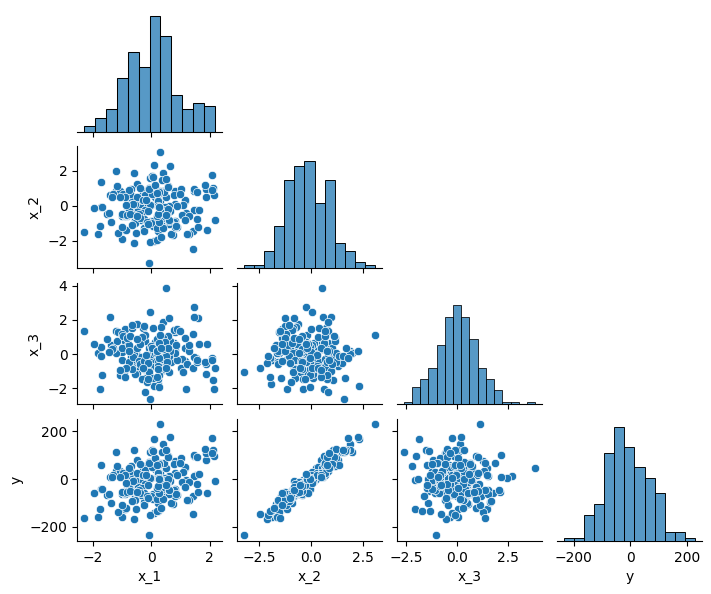

In [5]:
from sklearn.datasets import make_regression
import seaborn as sns
import numpy as np
import pandas as pd


X, y = make_regression(200, n_features=3, n_informative=2, noise = 0.5, random_state=42)
data = np.concatenate((X, y.reshape(-1, 1)), axis = 1)
df = pd.DataFrame(data, columns = ["x_1", "x_2", "x_3", "y"])
sns.pairplot(df, corner = True, height = 1.5, aspect=1.2)

The cell below shows regression results for all combinations which can be chosen for the predictor variables $x_1, x_2, x_3$. From the table, we can identify that $x_1$ alone explains most of the variation of $y$. Furthermore, including $x_2$ increases the level of variation which can be explained. Adding $x_3$ is not improving the explanatory power. By the signs of the predicted beta-coefficients we further would identify a positive relationship between $x_1, x_2$ and the target variable.

In [6]:
import pyfixest as pf
from itertools import combinations

predictors = ["x_1", "x_2", "x_3"]
predictor_combinations = []
for k in range(1,4,1):
    for subset in combinations(predictors, k):
        predictor_combinations.append(list(subset))

regressions = {}
for nbr, predictor_combination in enumerate(predictor_combinations):
    model_string = f"y ~ {' + '.join(predictor_combination)}"
    regressions[f"model_{nbr+1}"] = pf.feols(
        model_string,
        data = df
    )

pf.etable(list(regressions.values()))

GT(_tbl_data=  level_0        level_1                       0                       1  \
0    coef            x_1  25.789*** <br> (5.762)                           
1    coef            x_2                          72.930*** <br> (1.450)   
2    coef            x_3                                                   
3    coef      Intercept   -10.783* <br> (5.148)      1.542 <br> (1.468)   
4   stats   Observations                     200                     200   
5   stats      S.E. type                     iid                     iid   
6   stats  R<sup>2</sup>                   0.092                   0.927   

                     2                       3                       4  \
0                       22.935*** <br> (0.041)  25.474*** <br> (5.773)   
1                       72.212*** <br> (0.036)                           
2  -6.161 <br> (5.351)                             -4.859 <br> (5.126)   
3  -8.901 <br> (5.376)      0.003 <br> (0.037)   -10.550* <br> (5.155)   
4                  200                     200                     200   
5                  iid                     iid                     iid   
6                0.007                   1.000                   0.096   

                        5                       6  
0                          22.933*** <br> (0.041)  
1  72.850*** <br> (1.455)  72.210*** <br> (0.036)  
2     -1.168 <br> (1.451)     -0.040 <br> (0.036)  
3      1.581 <br> (1.470)      0.005 <br> (0.037)  
4                     200                     200  
5                     iid                     iid  
6                   0.928                   1.000  , _body=<great_tables._gt_data.Body object at 0x35da51640>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, column_label='(5)', column_align='center', column_width=None), ColInfo(var='5', type=<ColInfoTypeEnum.default: 1>, column_label='(6)', column_align='center', column_width=None), ColInfo(var='6', type=<ColInfoTypeEnum.default: 1>, column_label='(7)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x35da32de0>, _spanners=Spanners([SpannerInfo(spanner_id='y', spanner_level=1, spanner_label='y', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2', '3', '4', '5', '6'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x35da310a0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, categor

How do we use this for the analysis of financial stock market reactions towards firm disclosure in textual form? If we only would include the prediction of the stock market reaction we can estimate a regression model of the form:

$$
cr_{it, w} = \beta_0 + \beta_1 + \hat{cr}_{it, w} + \epsilon_{it}
$$

where the index $i$ represents companies and $t$ is the time step of event which occurs at $t$ for company $i$. This means we use the prediction as a explanatory variable. A large value of $R^2$ would indicate predictions being close to realizations, thus, explaining a large amount of the variation of stock market reactions. However, if further feature variables exist which also are able to explain the variation of $cr_{t, w}$, not including them can cause a bias for the estimator of $\beta_1$, thus, false quantification of its impact. This is why we should further add other feature variables to the regression which may be related to $cr_{t, w}$. From the literature, it is known that, e.g., the size of a company or its book-to-market value are related to the returns of a company. This is why they also might be related to cumulative excess or abnormal returns. Thus, the regression usually also includes further variable which are called control variables $C$:

$$
cr_{it, w} = \beta_0 + \beta_1 \hat{cr}_{it, w} + \mathbf{\gamma} C_{it} + \epsilon_{it}
$$

Without going to much into the details, for econometric reasons we further often include a constant parameter which is different for every company and a specific time period $t'$, e.g., a quarter or year. The regression becomes:

$$
cr_{it, w} = \beta_i + \beta_{t'} + \beta_1 \hat{cr}_{it, w} + \mathbf{\gamma}^T C_{it} + \epsilon_{it}
$$

Even though it looks more complicated, the interpretation in terms of adjusted $R^2$ and $\beta$ coefficients remain as before. 

## Stock market reactions and term frequencies 

Two popular papers which investigate the relation between the sentiment of company reports and earning call transcripts and stock market reactions are by [Loughran and McDonald (2011)](https://www.uts.edu.au/sites/default/files/ADG_Cons2015_Loughran%20McDonald%20JE%202011.pdf) and [Frankel et. al (2022)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3845780).

### When is a liability not a liability?

Loughran and MacDonald (2011) do not create predictions for financial sentiment, however, as described in the former chapters, they define a finance specific dictionary and count the frequency of negative tone in form 10-K annual filings of stock market listed companies. This variable is called Fin-Neg in the table of their paper below. The ability of this variable to explain the variation the cumulative excess return over the annual report's disclosure is compared to the negative tone measured by words from a more common dictionary that is not finance specific (H4N-Inf). 

If you take a look in the table below, you also see further variables which are included as control variables. Furthermore the Average $R^2$ is the average of $R^2$ values over multiple regression from different quarters. Also the displayed coefficients are averages of estimated coefficients over all quarters. Values in curly brackets are t-statistics which can be used for statistical inference. Under normality of the t-value, absolute values exceeding $1.645$ are the ones which would reject the null hypothesis of no impact under common significance levels. Proportional Weights are the frequencies of negative words in annual reports, the two columns to the right exhibit results when negative terms are weighted by their inverse document frequencies before aggregation. 

If we take a look at the two columns referring to the proportional weights, we observe a negative impact of negative tone on stock market reactions. The interesting take away is that the impact of the variable using the finance specific dictionary is statistically different from zero, while the one using the common dictionary is not. At the same time, variables of both dictionaries exhibit a negative impact on stock market reactions that is statistically different from zero. Thus, investors seem to react towards textual information of annual reports. Nevertheless, this result should not be overstated as the average value of $R^2$ scores is relatively small. This indicates that only little of the actual variation of stock market reactions can be explained by the control and text variables. This is rather common in the financial domain which is largely exposed to randomness and lacks of strong deterministic relationships between firm variables and stock market developments. 

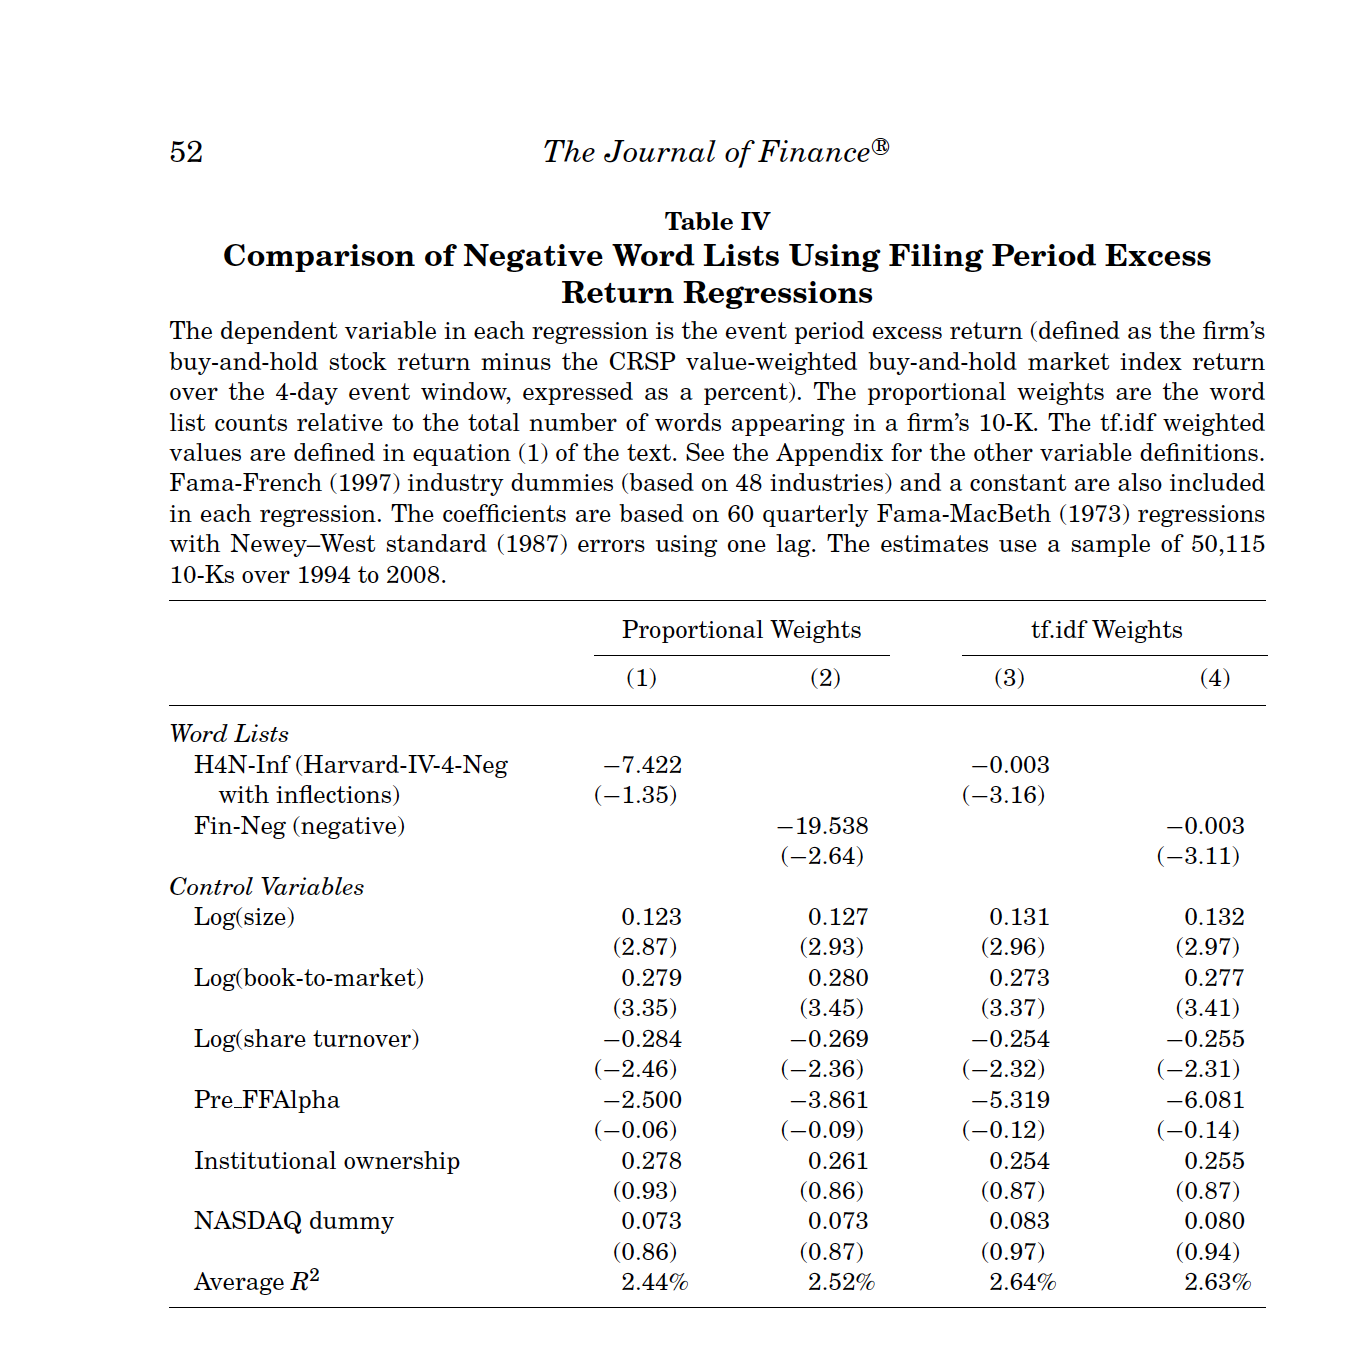

In [7]:
from IPython.display import Image
Image(filename='lmcd_results_table.png', width = 700) 

### Disclosure Sentiment: Machine Learning vs Dictionary Methods

The study from above is repeated by Frankel et. al (2022) using data up to more recent time periods. They find that the impact of negative tone measured by the dictionary of Loughran and MacDonald seems to vanish. Three variables are examined:

* Tone: number of positive words minus negative words divided by the number of positive and negative words
* Pos Tone: frequency of positive words
* Neg Tone: frequency of negative words

Each of them do not exhibit a considerable impact from a statistical impact for the larger time period between 1996 and 2019. However, the authors show two more things in their paper:

1. Machine learning based sentiment predictions as described in this chapter exhibit a significant impact to explain the variation of stock market reactions.
2. By far more variation can be explained for cumulative abnormal returns surrounding earning conference calls in comparison to annual reports.

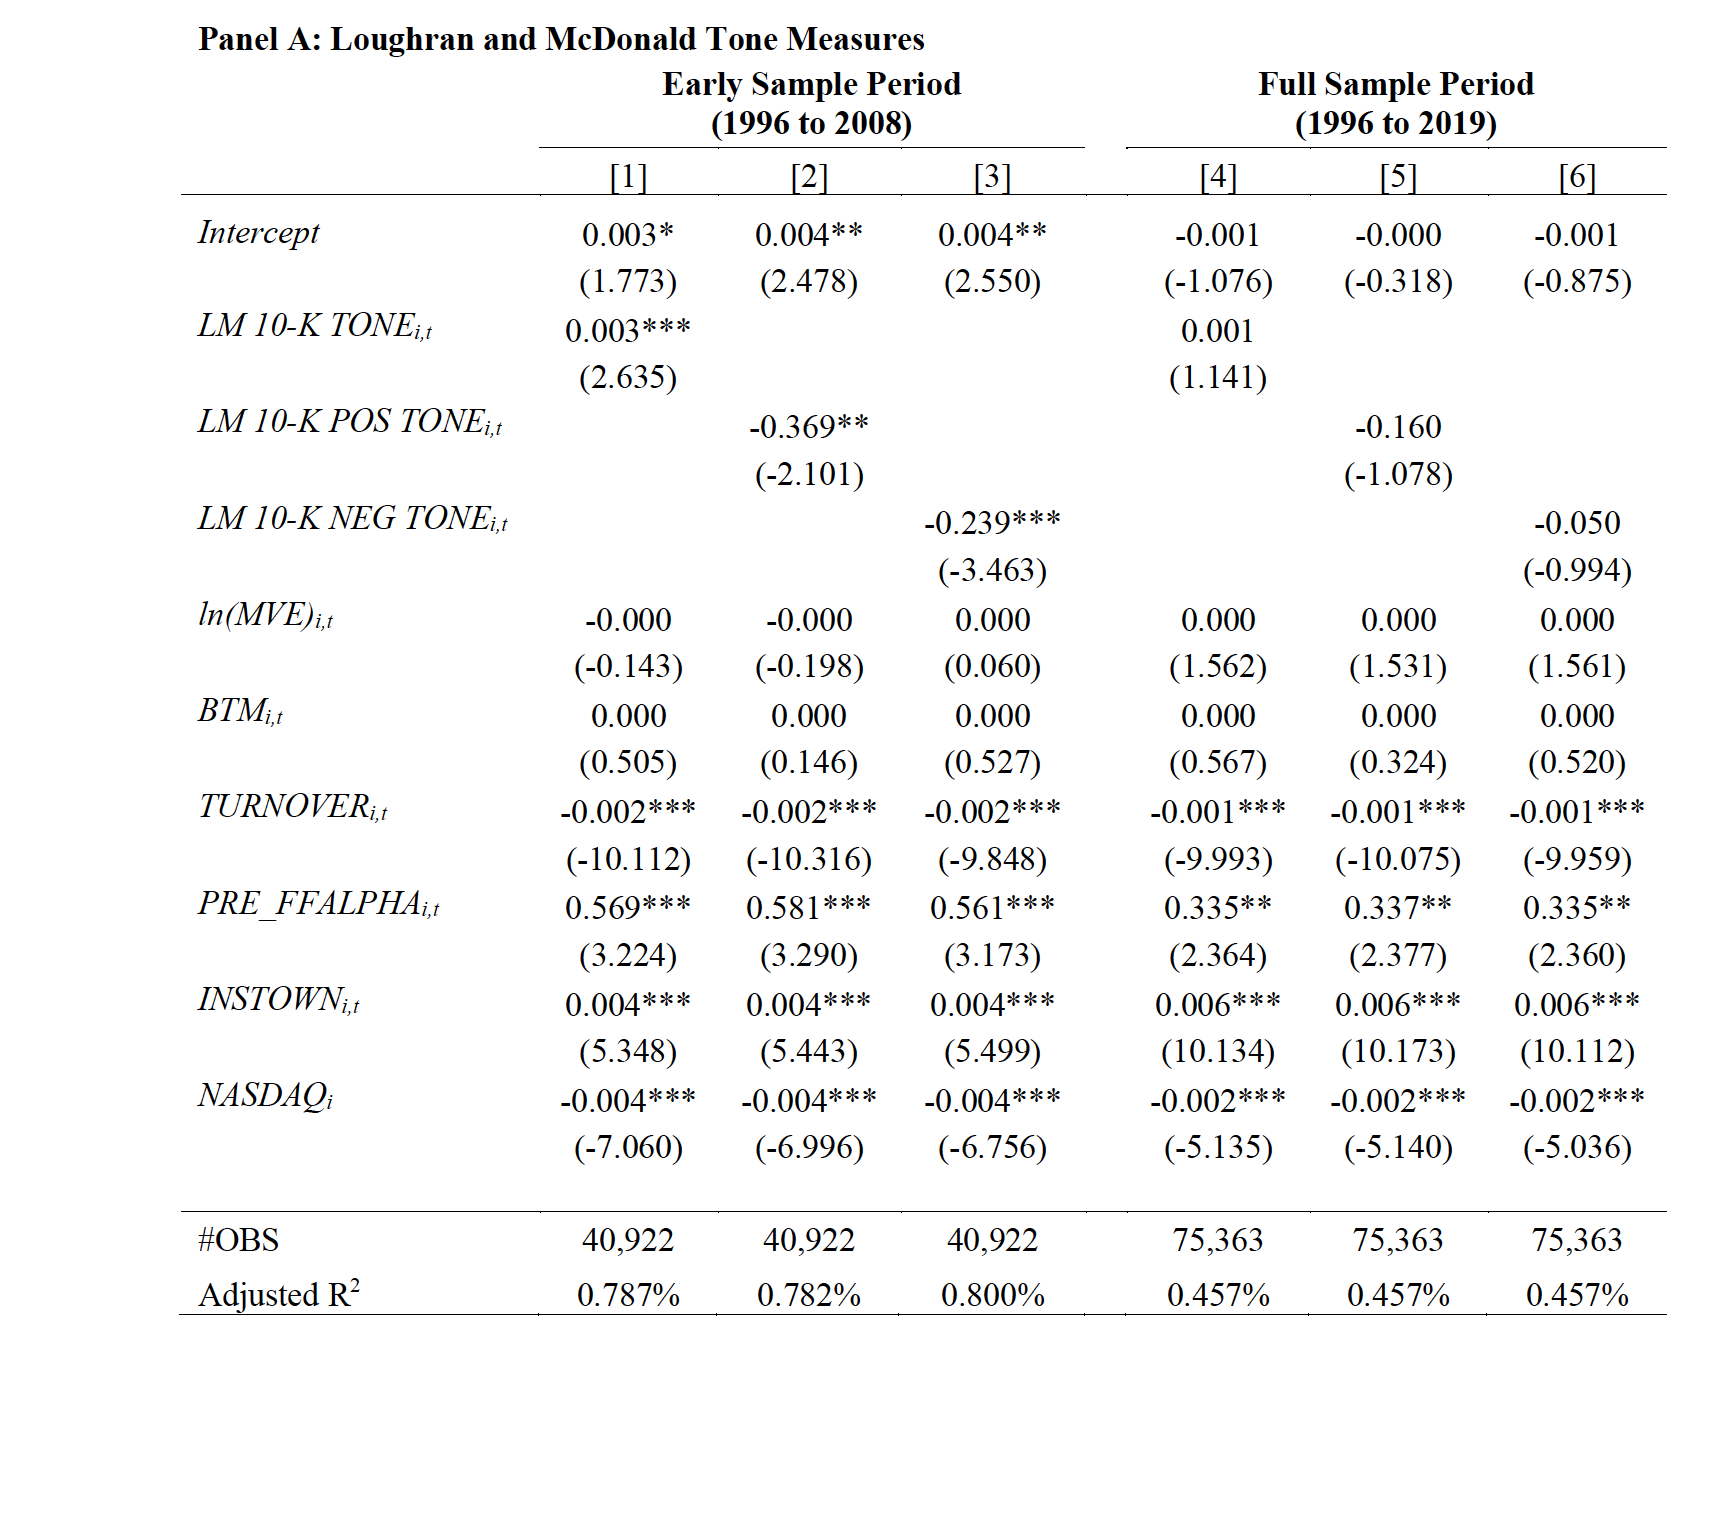

In [8]:
from IPython.display import Image
Image(filename='frankel_1.png', width = 700) 

In their paper, they compare different machine learning models, but random forests which are trained on uni- and bigram counts of documents exhibit the best prediction performance. The table below contrasts the impact of random forest sentiment prediction (RF) to the Loughran and MacDonald tone (LM) and the one derived by the common Harvard dictionary (HARV). Each of the variables has a positive impact on the stock market reaction around a earning call, however as can be seen by the adjusted $R^2$, the random forest sentiment variable is at least twice as high as for the other variables. This indicates that the random forest prediction is capturing the financial sentiment in a more precise manner.

 Comparing the $R^2$ levels of the table above (10-K) and the one below (earning calls), demonstrates that much more of the stock market reaction to earning calls is explainable by control variables and the text variable. A reason for this may lie in the nature of both events. Earning calls are usually before annual or quarter reports are released. Furthermore, they are less prepared and may allow analysts and investors to elicit more relevant information from firm representatives. Thus, information released in 10-K reports are known before and included in asset prices before the event occurs.

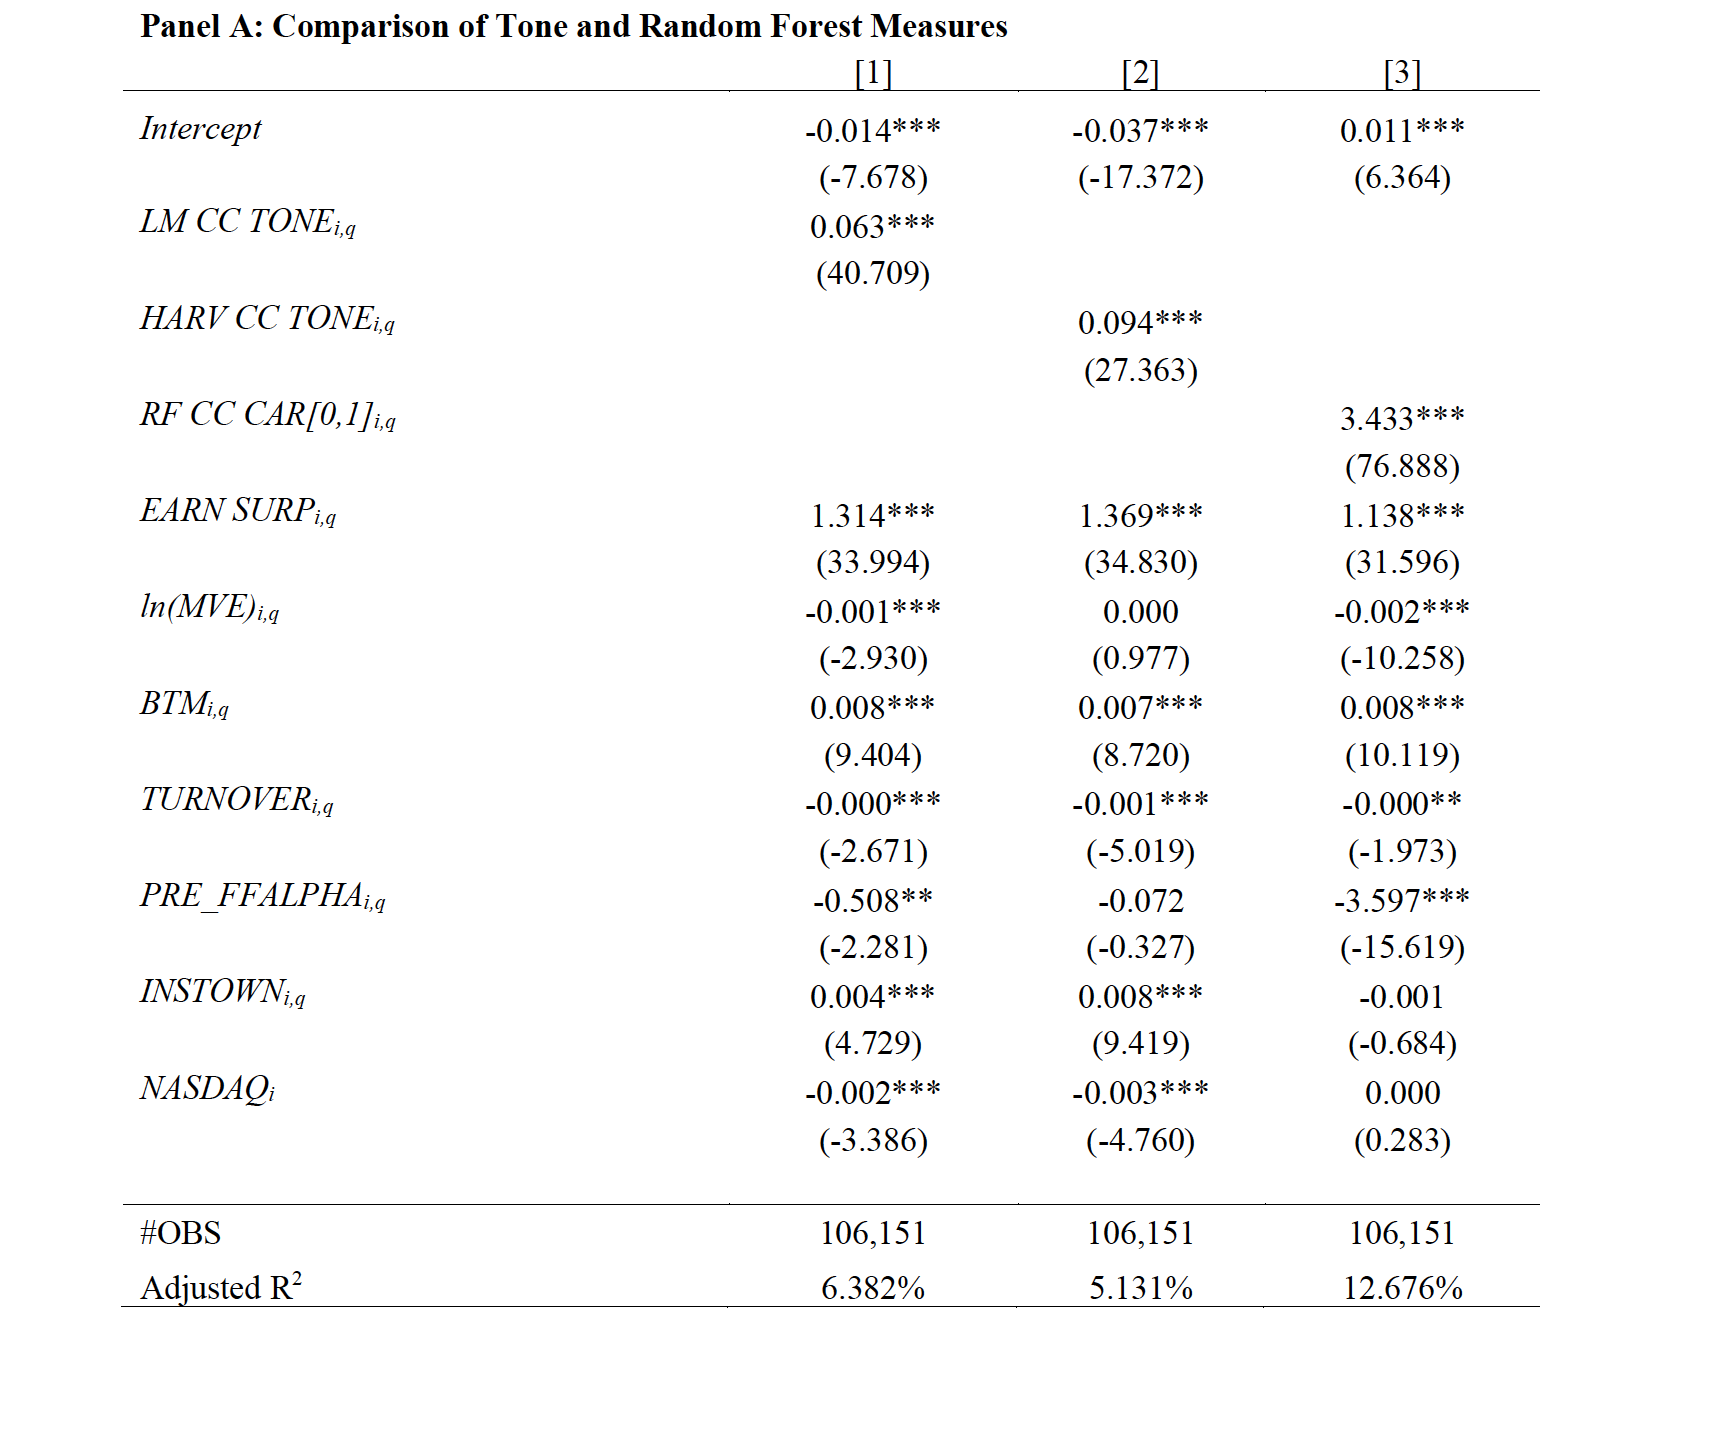

In [9]:
from IPython.display import Image
Image(filename='frankel_2.png', width = 700) 

## Document similarity and its usage

The papers by Loughran and MacDonald (2011) as well as Frankel et al. (2022) rely upon term frequencies and directly model their relation to financial market sentiment. Besides, we also can find useful document similarity based approaches in the financial literature. Two very different but interesting application are presented by [Cohen et. al (2020)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1658471) and [Engle et. al (2020)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3317570). 

### Lazy Prices

In “Lazy Prices”, Cohen et al. (2020) explore the predictive power of linguistic changes in financial filings (10-K and 10-Q reports) on stock returns and firm performance. They rely on textual similarity measures, comparing term frequencies across different filing periods to identify meaningful changes in language and structure. The primary focus is on how subtle modifications in corporate disclosures signal shifts in company fundamentals, which investors often overlook. By employing these textual metrics, the paper quantifies “non-obvious” updates in filings and connects these changes to market inefficiencies, such as delayed investor reactions.

This approach leverages term frequency to assess semantic stability or drift, identifying linguistic updates as proxies for evolving firm-specific risks or opportunities. The authors use the insights to argue that markets fail to price in all relevant information promptly, creating opportunities for excess returns.

More concrete, the authors holistically analyze a universe of US companies. Text documents are annual 10-K and quarter 10-Q reports. To quantify the similarity of firm reports, they use use four different metrics:

* Cosine similarity
* Jaccard similarity 
* Minimum edit distance
* Simple similarity

All measures are determined between two documents. For instance, cosine similarity uses the set of all terms which occur in both documents, determines their frequencies per document and calculates the cosine similarity between those vectors. Given the two documents:

* $D_1$: financial data analytics
* $D_2$: financial data analysis

we collect the dictionary by: [financial, data, analytics, analysis]

The term frequency vectors are:

* $TF_1$: [1, 1, 1, 0]
* $TF_1$: [1, 1, 0, 1]

The dot-product is: $(1 \cdot 1) + (1 \cdot 1) + (1 \cdot 0) + (0 \cdot 1) = 2$

The length of each vector is: $\sqrt{3}$

This would result in the cosine similarity:;

$$
d_{cosine} = \frac{2}{\sqrt{3} \sqrt{3}} = \frac{2}{3} \approx 0.667 
$$

The highest effect sizes are given for the Jaccard similarity in the paper, so let us also take a look how it is defined. The Jaccard similarity compares the documents based on the overlap of terms in their sets.

First, we need to define the sets of terms in both documents:

* $D_1$: (financial, data, analytics)
* $D_2$: (financial, data, analysis)

Next, we determine the intersection and union:

* $D_1 \cap D_2 $: (financial, data)
* $D_1 \cup D_2 $: (financial, data, analytics, analysis)

Finally, Jaccard similarity is the ratio for number of elements in the intersection and the union:

$$
d_{jaccard} = \frac{|D_1 \cap D_2|}{|D_1 \cup D_2|} = \frac{2}{4} = 0.5
$$

In their paper, they always compare a report with its counterpart from the previous year, e.g., report for the first quarter in 2023 with the one in the first quarter in 2024. The analysis is done with data between 1995 and 2014. On the firm level, they conduct monthly regressions which regress the next month's return upon the similarity measures and control variables. See the table from their paper below. Each of the similarity measures has a positive sign and is statistically different from zero (at a significance level of at 5\%). This implies that companies with lower similarity do have a lower expected return. From a asset pricing perspective, this means investors demand a premium for companies that do not change their reports. This would only make sense if changes are mostly associated with positive company developments and a decrease in company risk. 

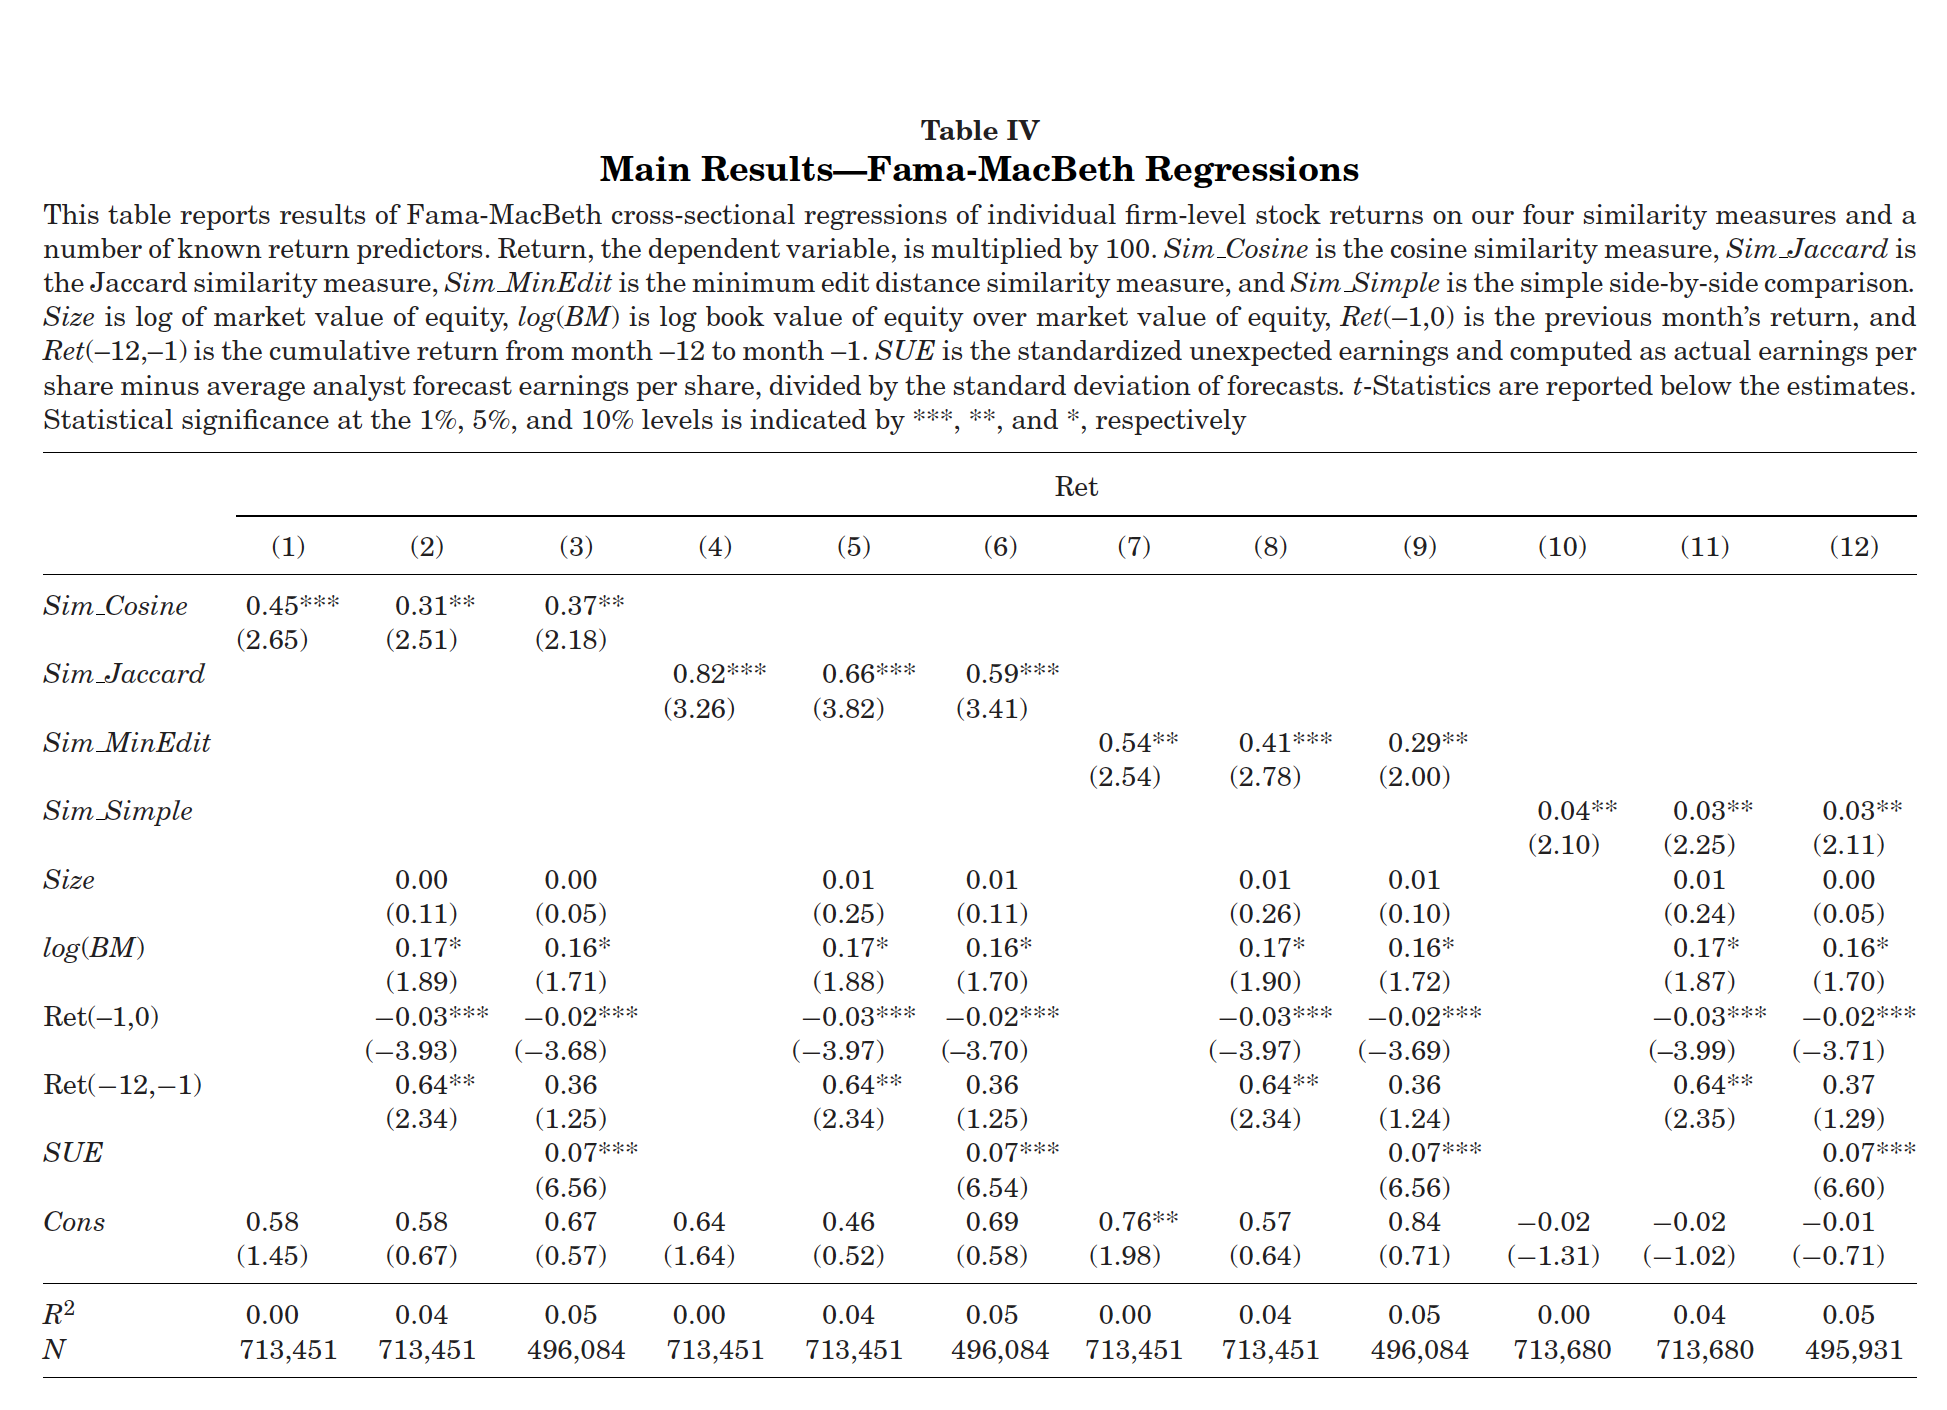

In [10]:
from IPython.display import Image
Image(filename='lazy_prices_regression.png', width = 800) 

However, the opposite seems to be true as they conduct another regression to get further insights of document changes. The regression table below regresses one of their similarity metrics on sentiment, uncertainty, litigious and CEO references in document changes. The results show that similarities decrease if more negative, litigious and uncertainty words are used or if the change is announcing the change of the company's CEO or CFO. This creates a puzzling result as changes in the document seem to be related to aspects creating uncertainty and risk of the company. At the same time, investors want to be less compensated when holding companies with higher document changes.





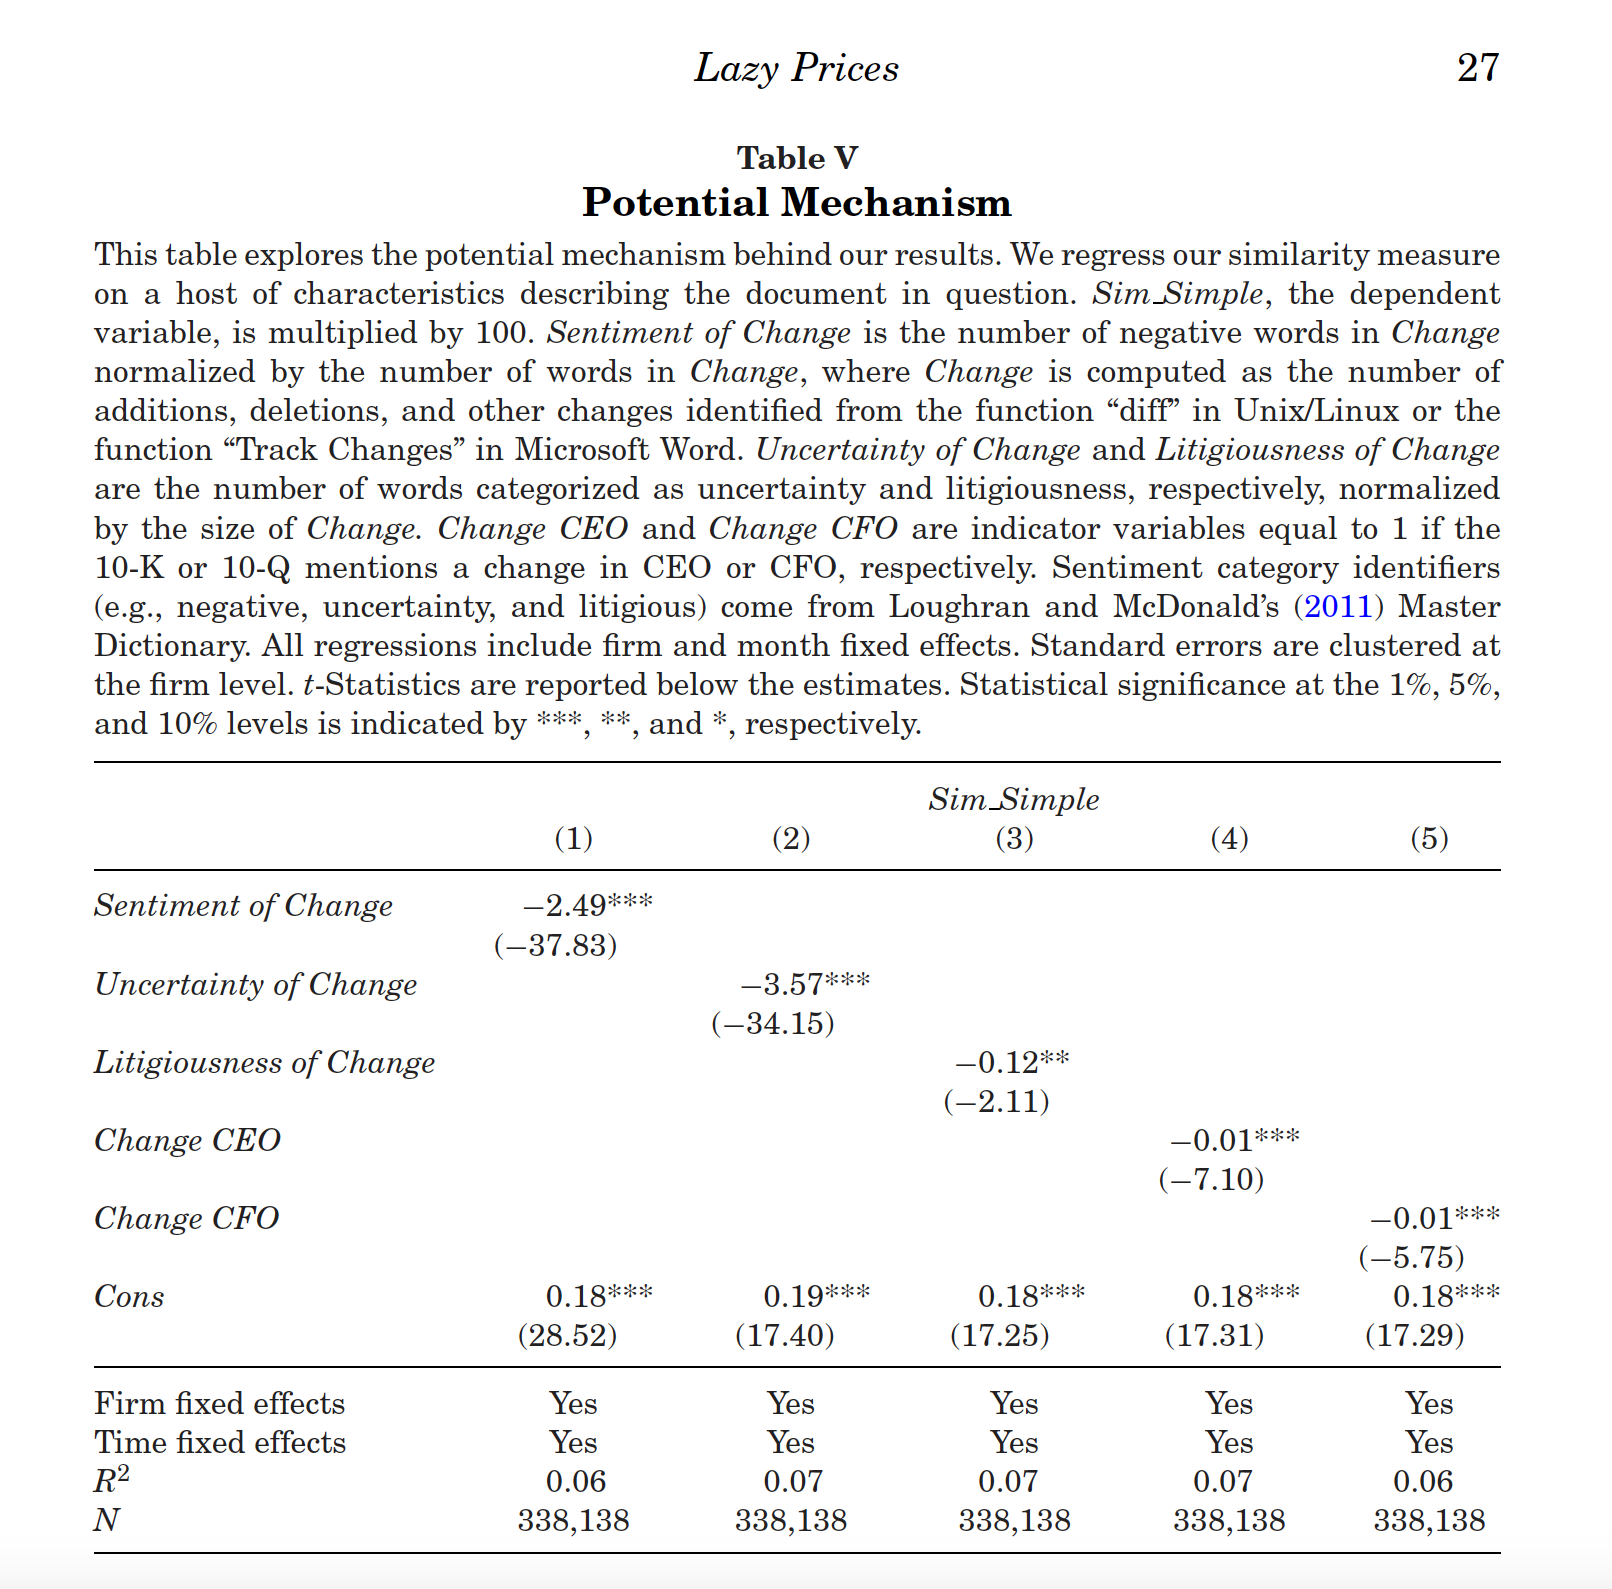

In [11]:
from IPython.display import Image
Image(filename='lazy_prices_regression_2.png', width = 600) 

The only explanation which makes this result plausible is, that investors fail to directly include the information of the document changes at the time they are revealed. This seems to be true and revealed by a portfolio analysis in the paper. Based on the document similarity, they build two portfolios. One containing companies with the least document changes and one with the highest document changes. Over time portfolio components are added and deleted according to their current document similarity. To extract the difference between the two portfolios we take a look at the difference in returns of the portfolio with the least and the most changes. This is from the paper's appendix. 

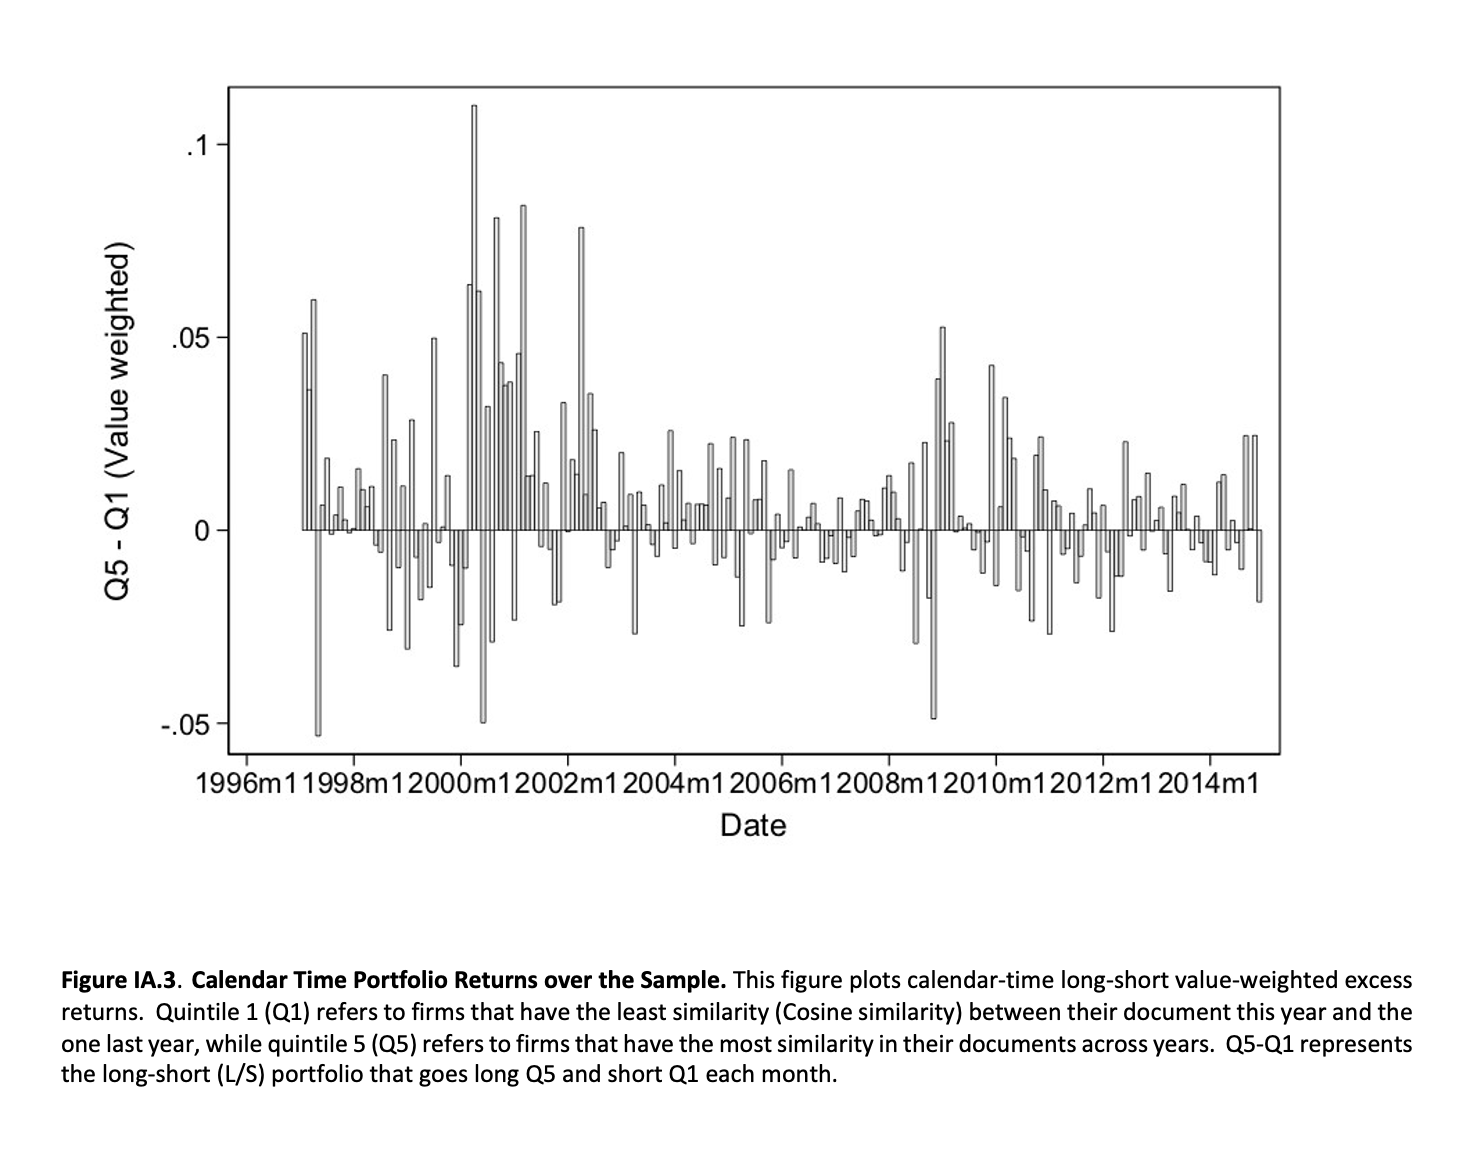

In [12]:
from IPython.display import Image
Image(filename='lazy_prices_pf_returns.png', width = 800) 

As we can see the portfolio of least changers outperforms the most changers in most of the months, predominately in the early 2000s where the dot-com crisis took place. This is true when controlling for risk factors. To identify the origin of the outperformance, the figure below exhibits averages of cumulative abnormal returns after report disclosure. It gets clear that companies with high changes in their company reports experience a decrease in market value over time, not at the event of information disclosure, but, months after it. This is quite uncommon for efficient markets which immediately process information into the companies' stock market prices. 

Thus, the paper reveals that investors seem to be unable to detect information which is relevant for the companies' value. Note that this is done by a rather simply method of using term frequencies and cosine similarity.

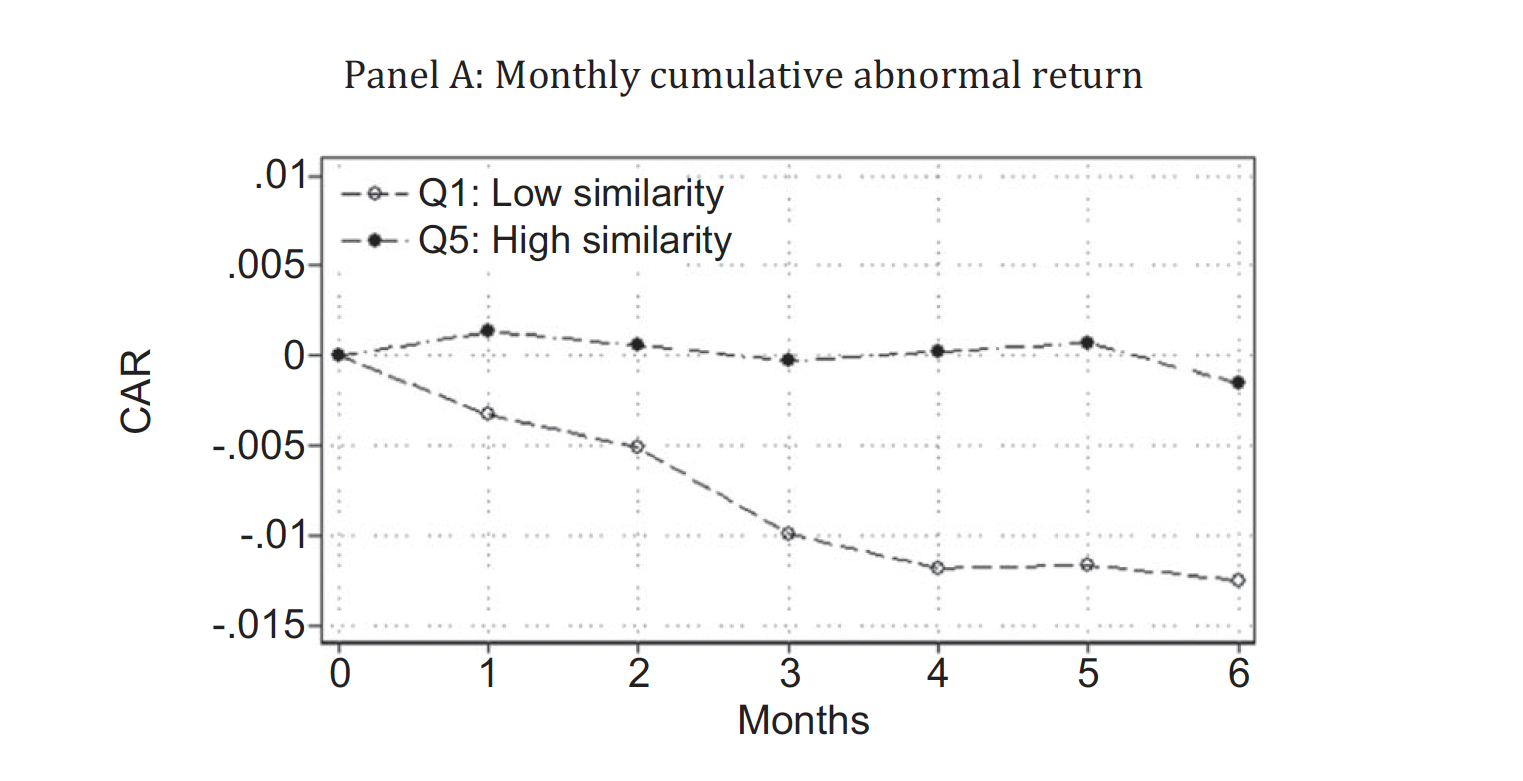

In [13]:
from IPython.display import Image
Image(filename='lazy_prices_pf_returns2.png', width = 700) 

### Hedging Climate Change News

The paper by Engle et al. (2020), Hedging Climate Change News, addresses the growing need to manage climate-related risks in financial markets. Climate risk is increasingly recognized as a critical factor affecting global economies due to its long-term, systemic, and non-diversifiable nature. These risks stem from both physical impacts (e.g., extreme weather events, rising sea levels) and transitional challenges (e.g., regulatory changes, shifts to low-carbon economies).

As investors and companies seek to mitigate these uncertainties, traditional hedging tools like futures or insurance contracts face limitations. For example, the long-term horizon and correlated nature of climate risks make it difficult for counterparties to credibly ensure payouts during a widespread crisis. In this context, dynamically constructed hedge portfolios using publicly traded assets, as proposed by Engle et al. (2020), are critical. These portfolios offer a feasible approach to offset the financial impacts of climate risks by aligning market exposures with innovations in climate news, a key driver of investor sentiment and decision-making.

More concrete, in their paper, they use term frequency analysis to construct indices that capture the intensity and sentiment of climate change coverage in media outlets. They develop the WSJ Climate Change News Index, which measures the prevalence of climate-related terms in The Wall Street Journal. This index is built using textual corpora, where climate-related term frequencies are weighted using methods like Term Frequency-Inverse Document Frequency (TF-IDF) and cosine similarity to authoritative climate change texts.

The objective here is to capture “innovations” in climate news—unexpected shifts in media coverage that might influence investor perceptions of climate risks. These innovations serve as inputs for constructing hedge portfolios that aim to mitigate the financial impact of climate-related risks. Thus, term frequency is not merely used to identify changes in text but to model a market-relevant risk factor.

Let us quickly take a look how, the climate change index is determined with help of a minimum example. In their paper, they collect documents whose emphasis lies on climate change (e.g., IPCC reports) and news articles of the wall street journal. 

* Climate documents:
    * Document 1: "greenhouse gas emissions increase global warming"
    * Document 2: "renewable energies help to reduce greenhouse gas emissions"

* News articles:
    * Article 1: "greenhouse gas emissions are a major driver of future economic losses"
    * Article 2: "the markets go up these days"

In the original paper, TF-IDF vectors for every document are generated. Hereby, there is only one climate document which includes the term frequencies from all climate documents. Furthermore, a newspaper document is the aggregate of all news articles for a single day. Thus, the frequencies of all articles within a day are used for determining the news TF-IDF vectors. 

In our example below, we have two articles from climate reports (d1, d2) and news articles from two days (a1, a2). Furthermore, we are going to ignore inverse document frequencies for our example. In a first step we create the unique set of terms and remove stop words.

In [14]:
d1 = "greenhouse gas emissions increase global warming"
d2 = "renewable energies help to reduce greenhouse gas emissions"
a1 = "greenhouse gas emissions are a major driver of future economic losses"
a2 = "the markets go up these days"

terms = []
for i in [d1, d2, a1, a2]:
    terms.extend(i.split())
terms = list(set(terms))

stop_words = ["the", "a", "are", "of", "to"]
terms = [t for t in terms if not(t in stop_words)]
terms

['driver',
 'economic',
 'go',
 'gas',
 'up',
 'these',
 'emissions',
 'warming',
 'greenhouse',
 'major',
 'reduce',
 'losses',
 'global',
 'future',
 'renewable',
 'help',
 'days',
 'energies',
 'markets',
 'increase']

Next, we determine the term frequencies.

In [15]:
import pandas as pd

def term_frequencies(doc):
    counts = [0] * len(terms)
    for i, t in enumerate(terms):
        if t in doc.split():
            counts[i] = 1
    return counts

tfs = pd.DataFrame(columns = terms)
for i, doc in enumerate([d1, d2, a1, a2]):
    tfs.loc[i] = term_frequencies(doc)

tfs.index = ["d1", "d2", "a1", "a2"]
tfs

driver  economic  go  gas  up  these  emissions  warming  greenhouse  \
d1       0         0   0    1   0      0          1        1           1   
d2       0         0   0    1   0      0          1        0           1   
a1       1         1   0    1   0      0          1        0           1   
a2       0         0   1    0   1      1          0        0           0   

    major  reduce  losses  global  future  renewable  help  days  energies  \
d1      0       0       0       1       0          0     0     0         0   
d2      0       1       0       0       0          1     1     0         1   
a1      1       0       1       0       1          0     0     0         0   
a2      0       0       0       0       0          0     0     1         0   

    markets  increase  
d1        0         1  
d2        0         0  
a1        0         0  
a2        1         0

Afterwards, we aggregate term frequencies over all climate reports.

In [16]:
climate_vector = tfs.loc[["d1", "d2"], :].sum().to_frame("climate").transpose()
climate_vector

driver  economic  go  gas  up  these  emissions  warming  greenhouse  \
climate       0         0   0    2   0      0          2        1           2   

         major  reduce  losses  global  future  renewable  help  days  \
climate      0       1       0       1       0          1     1     0   

         energies  markets  increase  
climate         1        0         1

If we calculate the cosine similarity, we determine the dot-product of two vectors and normalize them by their length. The dot-product is the sum of elementwise multiplication. Thus, for our example, if we take a look at the elementwise multiplication for the climate frequency and the news vectors, we could observe overlapping words of climate reports and news of article 1. 

In [17]:
climate_vector * tfs.loc["a1"]

driver  economic  go  gas  up  these  emissions  warming  greenhouse  \
climate       0         0   0    2   0      0          2        0           2   

         major  reduce  losses  global  future  renewable  help  days  \
climate      0       0       0       0       0          0     0     0   

         energies  markets  increase  
climate         0        0         0

However, we could not identify any similarity of climate reports and the second article. 

In [18]:
climate_vector * tfs.loc["a2"]

driver  economic  go  gas  up  these  emissions  warming  greenhouse  \
climate       0         0   0    0   0      0          0        0           0   

         major  reduce  losses  global  future  renewable  help  days  \
climate      0       0       0       0       0          0     0     0   

         energies  markets  increase  
climate         0        0         0

Accordingly, we could identify the day of article 1 as a day with climate talk in the news and the day of article 2 where climate talk has not been relevant in the news. In broader terms, the paper’s approach focuses on identifying days when news articles contain language commonly associated with discussions about the consequences of climate change. The underlying assumption is that news coverage of climate-related topics often conveys information that heightens companies’ exposure to climate risks.

In the paper of Engle et. al (2020), this is done with daily Wall Street Journal news and the climate vector is build upon a large collection of documents and glossaries about climate change. To reveal the changes in climate risk, the index itself is created as changes (between subsequent days) of daily cosine similarities between the news articles and the climate vector. See the figure below from their paper which shows the development of the climate change index between 1985 and 2017. 

The goal of their paper is to create a portfolio whose value increases if the climate change index increases to hedge against an in crease in climate risk from the companies' perspective. This is where the actual "work" of the paper starts. However, this extract is the one using language modeling which is why we end the presentation here and leave interested readers to the original research article. 

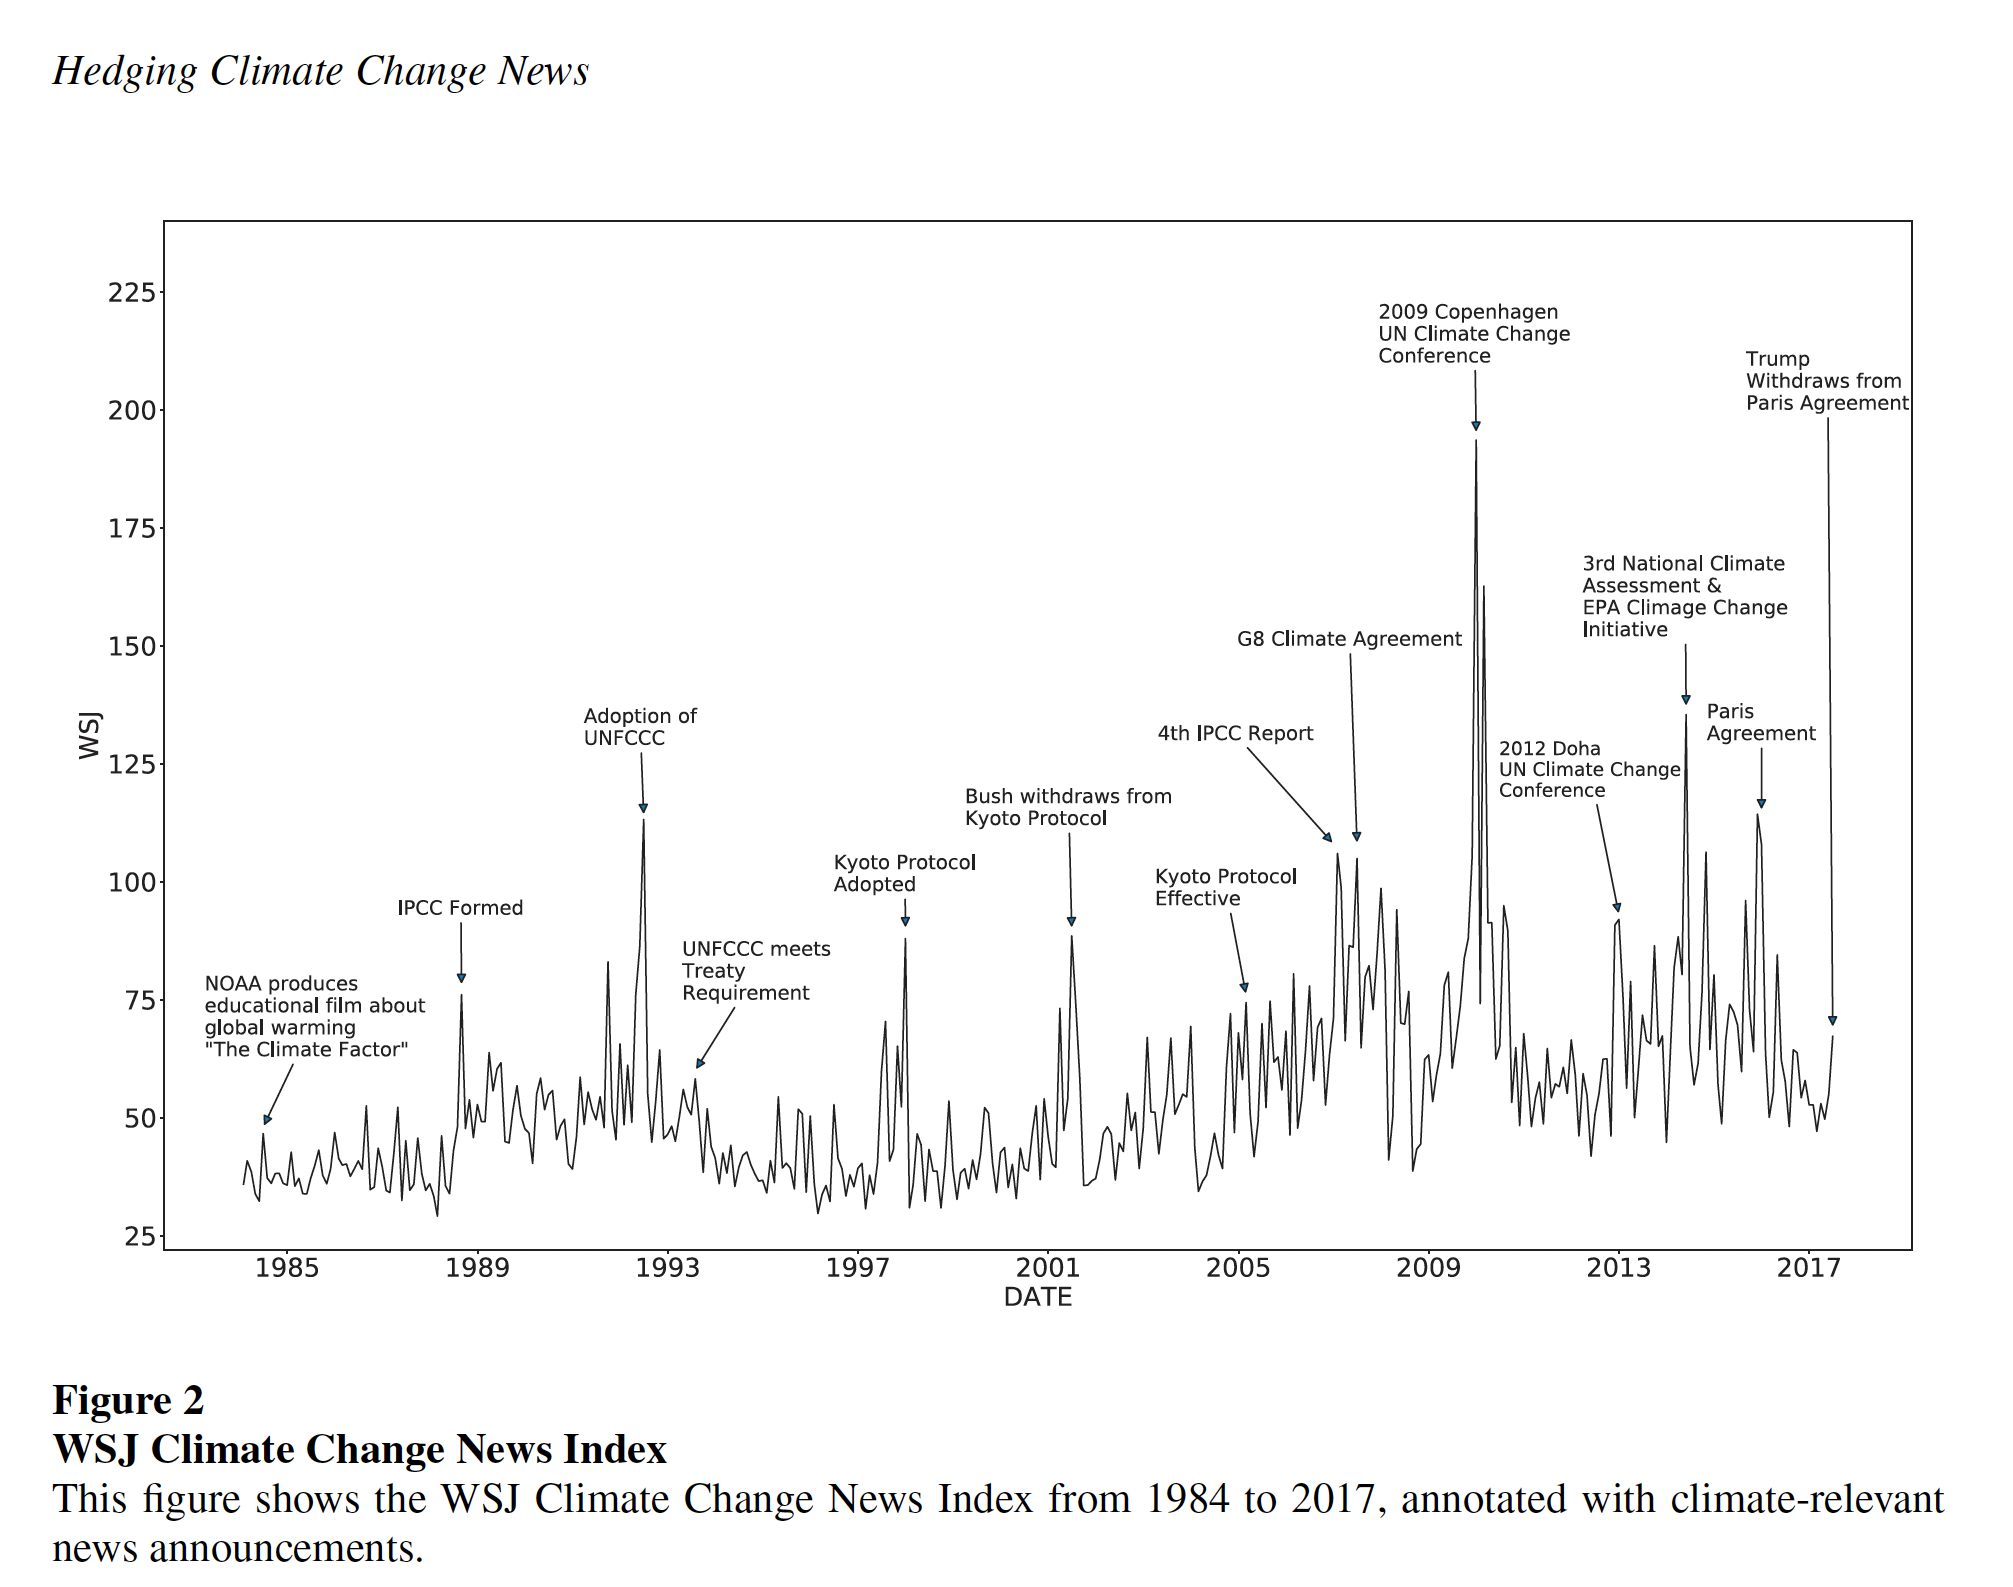

In [19]:
from IPython.display import Image
Image(filename='engle_hedging.png', width = 800) 

## Encoder models

We already examined the FinBERT paper and its applications in the paper by [Huang and Yiang (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/1911-3846.12832). Besides, most of financial research paper use encoder models like this to detect sequences related to a topic in longer financial reports. The appearance of such sequences is then used for varying company analyses. 

### Ask BERT: How Regulatory Disclosure of Transition and Physical Climate Risks Affects the CDS Term Structure

Popular applications are the identification of climate talk in company reports and earning calls. Two examples are presented by [Kölbel et. al (2022)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3616324) and [Sautner et. al (2024)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4596668). The paper by Kölbel et. al finetunes the general purpose BERT model to identify sentences related to climate disclosure in 10-K annual firm reports. They, distinguish between the categories "general", "physical", "transition". The latter two are both related to climate risk. 

Physical climate risk refers to the direct impacts of climate change on natural and human systems, such as extreme weather events like hurricanes and floods or long-term changes like rising sea levels and increasing temperatures. These risks primarily affect physical assets, ecosystems, and human health.

On the other hand, transition climate risk arises from the societal and economic adjustments required to move toward a low-carbon economy. This includes risks related to changing government policies, shifts in market dynamics, technological advancements, and reputational pressures. While physical risks deal with the tangible effects of climate change, transition risks are rooted in the challenges and disruptions associated with mitigating those effects and adapting to a sustainable future. 

Since 2010, the securities and exchange commission (SEC) in the US provided guidelines that four items  of form K reports:

* description of the business
* legal proceedings
* risk factors
* management’s discussion and analysis of financial condition and results of operations

may require disclosure related to climate change. Kölbel et. al (2022) use the finetuned BERT model to identify the fraction of climate related sentences in Item 1A of 10-K reports as this item is related to declaring risk factors for the business of a company.

In their analysis, they use this feature to examine if climate disclosure has explanatory for the creditworthiness of a company. The latter is measured by changes of credit default swap (CDS) spreads. The most important findings of the analysis are that higher levels of transition risk reduces creditworthiness by increasing CDS spreads, while the impact of physical disclosure levels are reversed. The former inducing higher company risk, the latter reduces uncertainty leading to higher levels of creditworthiness.

### Climate Value and Values Discovery in Earnings Calls

The paper explores how financial analysts address climate change concerns in corporate earnings calls, focusing on both financial (value) and non-financial (values) aspects. To identify climate related questions by analysis, they finetune the FinBERT model by Huang and Yiang (2022) using 2,400 sentences from earning call transcripts.

Key findings include that climate-related questions are increasingly frequent and tailored to specific industries and periods of relevance. Value-related discussions, which emphasize financial impacts like costs and investments, have gained relative importance over time, especially since 2018. In contrast, values-related inquiries address moral and regulatory concerns. Analysts’ climate discussions influence stock trading volumes, reflecting investor disagreement on interpreting climate information.

Interestingly, the paper finds that analysts’ interest in climate change is not an innate trait but a dynamic response to market and situational factors. Climate-focused analysts benefit in their careers, with value-centric discussions offering stronger predictive power for promotions and job mobility compared to values-centric ones. This study sheds light on the evolving role of analysts in integrating climate change into financial and ethical decision-making.

##